## Startup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyvista as pv
import jax
import jax.numpy as jnp

In [2]:
jax.config.update('jax_platform_name', 'cpu')

In [3]:
import os
mike_optics_code_location = os.path.join(os.path.abspath(""),'mike_raytrace')

%bookmark current_directory
%cd {mike_optics_code_location}
from raytrace import add_const_axis, const_to_vec3, vec_array_dot, vec_array_norm, vec_array_normalize, rotation_matrix
from raytrace import Rays, Rectangle, IdealLens, SphericalMirror, ToroidalMirror, PlaneGrating, ParabolicMirror, OffAxisParabola, OffAxisBiParabola
%cd current_directory

/home/mike/Documents/Utilities/mike_raytrace
(bookmark:current_directory) -> /home/mike/Documents/Proposals/2022_PICASSO
/home/mike/Documents/Proposals/2022_PICASSO


## Let's make an all-reflective SHS system

This section is translated from the spreadsheet [here](https://docs.google.com/spreadsheets/d/1O_tbvUVJ17s2xI6lIRDLGDcAe1r3KMTORPm7NLUffME/edit?usp=sharing) 

#### Spectral Choices

In [4]:
heterodyne_wavelength = 121.567# 486.135 # # nm, Lyman alpha

In [5]:
desired_spectral_range = 0.15 # nm, full width of solar Lyman alpha line
detector_full_width = 24 # mm, IUVS-style detector size
detector_full_pixel_format = 512 # although IUVS has 1024 pixels, the intensifier PSF FWHM is ~2 pixels wide
detector_fill_fraction_spectral = 0.9
detector_fill_fraction_spatial = 0.9

In [6]:
desired_width_at_detector = detector_full_width*detector_fill_fraction_spectral
desired_height_at_detector = detector_full_width*detector_fill_fraction_spatial
n_spectral_pixels = detector_full_pixel_format*detector_fill_fraction_spectral
minimum_resolvable_wavelength_difference = desired_spectral_range / n_spectral_pixels # nm
print(f'{minimum_resolvable_wavelength_difference = } nm')
max_resolving_power = heterodyne_wavelength/minimum_resolvable_wavelength_difference
print(f'{max_resolving_power = }')

minimum_resolvable_wavelength_difference = 0.0003255208333333333 nm
max_resolving_power = 373453.824


In [7]:
resolving_power = 375000
groove_density = 4960# 1200# 5670# # lines/mm, largest or second largest replica holographic groove density given in Horiba/JY catalog
margin_on_resolving_power = 0.25

grating_width = resolving_power/(4*groove_density*(1-margin_on_resolving_power))
print(f'{grating_width = } mm')

grating_width = 25.201612903225808 mm


Can order a 25 x 50 mm grating from JY (standard size) and only illuminate 22 x 44 mm 

In [8]:
grating_angle = np.arcsin(heterodyne_wavelength*1e-6*groove_density)
grating_angle_deg = np.rad2deg(grating_angle)
print(f'{grating_angle_deg = }')

grating_angle_deg = 37.08307230311133


#### interferometer choices

In [9]:
# not used in parabolic configuration
slit_image_fraction_inside_interferometer = 0.5

In [10]:
# !!! may be overriden later on
camera_grating_distance = 130. # mm

In [11]:
# extra space between collimator and camera
collimator_camera_pad_fraction = 0.1
collimator_camera_pad_distance = collimator_camera_pad_fraction*grating_width

grating_height = 2 * grating_width + collimator_camera_pad_distance
print(f'{grating_height = }')

grating_height = 52.9233870967742


#### telescope and slit choices

In [12]:
telescope_width = 30
telescope_f_number = 6
telescope_focal_length = telescope_width * telescope_f_number
print(f'{telescope_focal_length = } mm')

telescope_focal_length = 180 mm


In [13]:
slit_length_deg = 2.8
slit_length_rad = np.deg2rad(slit_length_deg)

#### configuration of exit optics

In [14]:
use_fold_mirror = False
use_parabolic_cylinders = True
use_reflective_exit_slit = False

if use_fold_mirror+use_parabolic_cylinders+use_reflective_exit_slit != 1:
    raise ValueError("Select only one of (use_fold_mirror, use_parabolic_cylinders, use_reflective_exit_slit)")

exit_horiz_angle_deg = 10.0
exit_horiz_angle = np.deg2rad(exit_horiz_angle_deg)

inf_focal_length = 1e6 # mm, infinity for the purposes of parabolic cylinder optics

#### off-axis angle to use for optics

In [15]:
# only used in early versions of the interferometer
off_axis_angle_deg = 0.0#-3.5
off_axis_angle_rad = np.deg2rad(off_axis_angle_deg)

#### spatial fringe rotation

In [16]:
n_spatial_fringes = 10.0
spatial_rotation_angle = n_spatial_fringes*heterodyne_wavelength*1e-6/(2*grating_width)
print(f'{spatial_rotation_angle = } = {np.rad2deg(spatial_rotation_angle)*3600}"')

spatial_rotation_angle = 2.4118892799999995e-05 = 4.974878750286487"


#### sensitivity estimate

In [17]:
slit_angular_width_rad = np.sqrt(8/resolving_power)*np.cos(grating_angle)
slit_angular_width_deg = np.rad2deg(slit_angular_width_rad)
print(f'{slit_angular_width_deg = }°')
slit_width = slit_angular_width_rad*telescope_focal_length
print(f'{slit_width = } mm')
slit_length = slit_length_rad*telescope_focal_length
print(f'{slit_length = } mm')

slit_angular_width_deg = 0.21111806492882523°
slit_width = 0.6632469618204903 mm
slit_length = 8.79645943005142 mm


In [18]:
mirror_reflectivity = 0.8

In [19]:
# does not include grating efficiency
estimated_IUVS_relative_throughput = (slit_angular_width_deg/0.06  # slit width advantage
                                      * mirror_reflectivity**9/(0.8)**6  # mirror reflectivity penalty
                                      * slit_length_deg/11.3  # slit length penalty
                                      * telescope_width**2/(13.3*20)) # telescope mirror size advantage
print(f'{estimated_IUVS_relative_throughput = }')

estimated_IUVS_relative_throughput = 1.510374232560203


### Grating

Let's make the center of the grating the center of the coordinate system and figure out everything else from there.

The direction of incoming light to the grating will be along +x, and outgoing light along -x. 

y-axis will be the dispersion direction, and the instrument will be stacked along the z-coordinate

In [20]:
grating = PlaneGrating(center=[0, 0, 0],
                        normal=[1.,0,0],
                        vdir=[0,0,1.],
                        grating_vector=[0,-1.,0],
                        groove_density=groove_density,
                        width=[grating_width, grating_height])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Side mirrors

In [21]:
mirror_rotation_angle = np.pi/4 - grating_angle/2
print(f'{np.rad2deg(mirror_rotation_angle)=}')

np.rad2deg(mirror_rotation_angle)=26.458463848444335


In [22]:
pilot_mirror_rotation_mat = rotation_matrix(mirror_rotation_angle, jnp.array([0,0,1]))
roof_mirror_rotation_mat = rotation_matrix(-mirror_rotation_angle, jnp.array([0,0,1]))

In [23]:
diffracted_beam_width = grating_width*np.cos(grating_angle)
print(f'{diffracted_beam_width=} mm')

diffracted_beam_width=20.104891840256503 mm


In [24]:
side_mirror_x_displacement = grating_width*((1.0 + 1.0/np.sin(np.pi/4.0 + grating_angle/2.0))/np.tan(grating_angle)
                                            - 0.5*np.cos(grating_angle))
# I derived this formula in Mathematica, 
#  it gives the minimum along-beam displacement of the side mirrors 
#  so that a roof mirror is just outside the beam incident on the grating
print(f'{side_mirror_x_displacement=}')

side_mirror_y_displacement = side_mirror_x_displacement*np.tan(grating_angle)
print(f'{side_mirror_y_displacement=}')

side_mirror_x_displacement=60.534533356857665
side_mirror_y_displacement=45.753800089202734


In [25]:
pilot_mirror_normal_without_spatial_rotation = jnp.matmul(pilot_mirror_rotation_mat, jnp.array([0,1,0]))
mirror_spatial_rotation_mat = rotation_matrix(spatial_rotation_angle, jnp.cross(jnp.array([0,0,1]), pilot_mirror_normal_without_spatial_rotation))

In [26]:
pilot_mirror = Rectangle(center=[side_mirror_x_displacement, -side_mirror_y_displacement, 0],
                         normal=jnp.matmul(mirror_spatial_rotation_mat, pilot_mirror_normal_without_spatial_rotation),
                         vdir=[0,0,1],
                         width=[diffracted_beam_width/np.cos(mirror_rotation_angle), grating_height],
                         reflectivity=1.0, transmission=0.0)

In [27]:
diffracted_beam_width/np.cos(mirror_rotation_angle)

22.457102816179606

In [28]:
grating_height

52.9233870967742

In [29]:
def get_roof_mirror_components(center, normal, vdir, width, **kwargs):
    center = jnp.array(center)
    normal = vec_array_normalize(normal)
    vdir = jnp.array(vdir)
    vdir = vdir - normal*jnp.dot(vdir, normal)
    vdir = vec_array_normalize(vdir)

    if not hasattr(width, '__len__'):
        width = jnp.float64(width)
        width = jnp.array([width, width])
    width = jnp.array(width)
    
    udir = jnp.cross(normal, vdir)
    
    # mirror is the bottom component of the roof mirror
    lower_mirror_rotation_mat = rotation_matrix(-np.pi/4, jnp.array(udir))
    upper_mirror_rotation_mat = rotation_matrix(np.pi/4, jnp.array(udir))
    
    lower_normal = jnp.matmul(lower_mirror_rotation_mat, normal)
    upper_normal = jnp.matmul(upper_mirror_rotation_mat, normal)
    
    lower_vdir = jnp.matmul(lower_mirror_rotation_mat, vdir)
    upper_vdir = jnp.matmul(upper_mirror_rotation_mat, vdir)
    
    lower_width = jnp.array([width[0], width[1]*jnp.sqrt(2)/2])
    upper_width = jnp.array([width[0], width[1]*jnp.sqrt(2)/2])
    
    lower_center = center - lower_vdir*lower_width[1]/2.
    upper_center = center + upper_vdir*upper_width[1]/2.
    
    lower_mirror = Rectangle(center=lower_center,
                             normal=lower_normal,
                             vdir=lower_vdir,
                             width=lower_width,
                             **kwargs)
    upper_mirror = Rectangle(center=upper_center,
                             normal=upper_normal,
                             vdir=upper_vdir,
                             width=upper_width,
                             **kwargs)
    
    return lower_mirror, upper_mirror

In [30]:
roof_mirror_width = diffracted_beam_width/np.cos(mirror_rotation_angle) + 2*grating_width*np.tan(mirror_rotation_angle)
print(f'{roof_mirror_width=}')
roof_mirror_lower, roof_mirror_upper = get_roof_mirror_components(center=[side_mirror_x_displacement, side_mirror_y_displacement, 0],
                                                                  normal=jnp.matmul(roof_mirror_rotation_mat, jnp.array([0,1,0])),
                                                                  vdir=[0,0,1],
                                                                  width=[roof_mirror_width, grating_height],
                                                                  reflectivity=1.0, transmission=0.0)

roof_mirror_width=47.541618112434385


### Spectral focal lengths

In [31]:
light_path_length_through_interferometer = (2*np.sqrt(side_mirror_x_displacement*side_mirror_x_displacement
                                                      +side_mirror_y_displacement*side_mirror_y_displacement)
                                            + 2*side_mirror_y_displacement)
print(f'{light_path_length_through_interferometer=}')

light_path_length_through_interferometer=243.26846405753923


In [32]:
distance_to_fringe_localization_plane = 0.5*light_path_length_through_interferometer / np.cos(grating_angle)**2
print(f'{distance_to_fringe_localization_plane=}')

distance_to_fringe_localization_plane=191.12126373548278


In [33]:
detector_grating_width_ratio = desired_width_at_detector/grating_width
print(f'{detector_grating_width_ratio=}')

detector_grating_width_ratio=0.857088


In [34]:
# we determine the required camera spectral focal length 
#   and the distance between the camera spectral focal plane and the detector 
#   simultaneously by solving the coupled equations
#   width_ratio = (d_camera_detector - f)/f
#   1/f = 1/d_camera_fringe_localization_plane + 1/d_camera_detector
#   d_camera_fringe_localization_plane = d_camera_grating + d_fringe_localization_plane

# camera_spectral_f = (camera_grating_distance + distance_to_fringe_localization_plane)*(detector_grating_width_ratio/(1+detector_grating_width_ratio))
# print(f'{camera_spectral_f = }')
# camera_spectral_f_number = camera_spectral_f / (grating_width * np.sqrt(2))
# print(f'{camera_spectral_f_number = }')

# camera_detector_distance = (camera_grating_distance + distance_to_fringe_localization_plane)*detector_grating_width_ratio
# print(f'{camera_detector_distance = }')

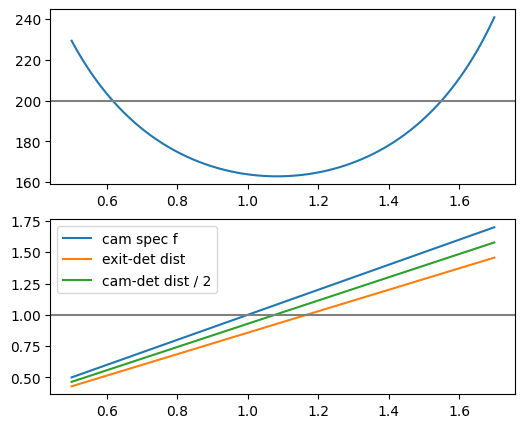

In [35]:
test_dist_ratios = np.linspace(0.5, 1.7, 100)
test_cam_spe_f = distance_to_fringe_localization_plane / (1 + 1/detector_grating_width_ratio - test_dist_ratios)
test_cam_gra_dist = test_cam_spe_f / test_dist_ratios
test_cam_det_dist = test_cam_spe_f * (1 + detector_grating_width_ratio)
text_exit_slit_det_dist = test_cam_det_dist - test_cam_spe_f

fig, (ax_abs, ax_rel) = plt.subplots(nrows=2, figsize=(6, 5), dpi=100)

ax_abs.plot(test_dist_ratios, test_cam_gra_dist)

ax_rel.plot(test_dist_ratios, test_cam_spe_f/test_cam_gra_dist)
ax_rel.plot(test_dist_ratios, text_exit_slit_det_dist/test_cam_gra_dist)
ax_rel.plot(test_dist_ratios, test_cam_det_dist/test_cam_gra_dist/2)
#ax_abs.axhline(side_mirror_x_displacement + diffracted_beam_width/2, color='0.5')
ax_abs.axhline(200, color='0.5')
ax_rel.axhline(1, color='0.5')
ax_rel.legend(['cam spec f', 'exit-det dist', 'cam-det dist / 2'])

In [36]:
# if we also require camera_spectral_f = camera_focal_length_grating_dist_fraction * camera_grating_distance, we obtain
camera_focal_length_grating_dist_fraction = 1.0
camera_spectral_f = distance_to_fringe_localization_plane / (1 + 1/detector_grating_width_ratio - camera_focal_length_grating_dist_fraction)
print(f'{camera_spectral_f = }')
camera_spectral_f_number = camera_spectral_f / (grating_width * np.sqrt(2))
print(f'{camera_spectral_f_number = }')

camera_grating_distance = camera_spectral_f / camera_focal_length_grating_dist_fraction
print(f'{camera_grating_distance = }')

camera_detector_distance = camera_spectral_f * (1 + detector_grating_width_ratio)
print(f'{camera_detector_distance = }')

exit_slit_detector_distance = camera_detector_distance - camera_spectral_f
print(f'{exit_slit_detector_distance = }')

camera_spectral_f = 163.80774169251742
camera_spectral_f_number = 4.596117137677613
camera_grating_distance = 163.80774169251742
camera_detector_distance = 304.2053914042738
exit_slit_detector_distance = 140.3976497117564


### Spatial focal lengths

Before we lay out the system we need to know spatial focal lengths for the components, which requires defining the telescope and collimator

In [37]:
collimator_spectral_f = grating_width*telescope_f_number
print(f'{collimator_spectral_f = }')

collimator_spectral_f = 151.20967741935485


In [38]:
# diagnostic: is telescope-collimator distance ~ camera-detector distance?
camera_detector_distance / (collimator_spectral_f + telescope_focal_length)

0.918467702316288

In [39]:
collimator_grating_distance = camera_grating_distance
collimator_spatial_f = 1./(1/collimator_spectral_f + 1/(collimator_grating_distance
                                                        + slit_image_fraction_inside_interferometer*light_path_length_through_interferometer))
print(f'{collimator_spatial_f = }')
collimator_spatial_f_number = collimator_spatial_f / grating_width
print(f'{collimator_spatial_f_number = }')

collimator_spatial_f = 98.84673207026941
collimator_spatial_f_number = 3.92223832854829


In [40]:
slit_magnification_by_collimator = ((collimator_grating_distance
                                     + slit_image_fraction_inside_interferometer*light_path_length_through_interferometer)
                                    /(collimator_spectral_f))
print(f'{slit_magnification_by_collimator = }')

slit_magnification_by_collimator = 1.8877229195434446


In [41]:
camera_spatial_f = 1/(1/camera_detector_distance + 1/(camera_grating_distance 
                                                      + (1-slit_image_fraction_inside_interferometer)*light_path_length_through_interferometer))
print(f'{camera_spatial_f = }')
camera_spatial_f_number = camera_spatial_f / grating_width
print(f'{camera_spatial_f_number = }')

camera_spatial_f = 147.26257162296002
camera_spatial_f_number = 5.843378841999053


In [42]:
slit_magnification_by_camera = camera_detector_distance / (camera_grating_distance 
                                                           + (1-slit_image_fraction_inside_interferometer)*light_path_length_through_interferometer)
print(f'{slit_magnification_by_camera = }')

slit_magnification_by_camera = 1.065734613022638


In [43]:
# diagnostic: how large is slit image relative to desired detector height?

total_slit_magnification = slit_magnification_by_collimator*slit_magnification_by_camera
print(f'{total_slit_magnification = }')

slit_image_length_at_detector = total_slit_magnification*slit_length
print(f'{slit_image_length_at_detector = }')

slit_image_ratio = slit_image_length_at_detector / desired_height_at_detector
print(f'{slit_image_ratio = }')

total_slit_magnification = 2.0118116551535974
slit_image_length_at_detector = 17.69681960546322
slit_image_ratio = 0.8192972039566304


### Camera

In [44]:
inout_rotation_axis = jnp.array([0,0,1])

in_angle = off_axis_angle_rad
off_axis_path_in_mat = rotation_matrix(in_angle, inout_rotation_axis)

out_angle = -off_axis_angle_rad
off_axis_path_out_mat = rotation_matrix(out_angle, inout_rotation_axis)

In [45]:
camera_center = grating._center + jnp.array([camera_grating_distance, 0, -0.5*(grating_width+collimator_camera_pad_distance)])

camera_rotate_down_angle_deg = 12.5
camera_rotate_down_angle = np.deg2rad(camera_rotate_down_angle_deg)
camera_rotate_down_mat = rotation_matrix(camera_rotate_down_angle, np.array([0, -1, 0]))
camera_out_vec = np.matmul(camera_rotate_down_mat, [-1, 0, 0])
camera_spectral_focal_point = camera_center + camera_spectral_f*camera_out_vec

# camera = OffAxisParabola(center = camera_center,
#                          axis_out = [-1,0,0],
#                          vdir = [0,0,1],
#                          focus = camera_spectral_focal_point,
#                          vfactor = camera_vfactor,
#                          width = grating_width)


if use_parabolic_cylinders:
    # camera focuses only in the spectral dimension
    camera_spatial_focal_point = camera_center + inf_focal_length*camera_out_vec
    camera = OffAxisBiParabola(center = camera_center,
                               axis_out = [-1,0,0],
                               vdir = [0,0,1],
                               focus_u = camera_spectral_focal_point,
                               focus_v = camera_spatial_focal_point,
                               width = grating_width)
else:
    # camera focuses in spectral and spatial dimension at different distances
    camera_spatial_focal_point = camera_center + camera_detector_distance*camera_out_vec
    camera = OffAxisBiParabola(center = camera_center,
                               axis_out = [-1,0,0],
                               vdir = [0,0,1],
                               focus_u = camera_spectral_focal_point,
                               focus_v = camera_spatial_focal_point,
                               width = grating_width)    

In [88]:
camera_spectral_focal_point

Array([  3.88289754,   0.        , -49.31537147], dtype=float64)

In [89]:
camera_spatial_focal_point

Array([-976132.19937824,       0.        , -216453.4748252 ], dtype=float64)

In [46]:
np.linalg.norm(camera_center-camera_spectral_focal_point) # spectral camera focal length

163.80774169251742

### Collimator and telescope

In [47]:
# version 2, off-axis confocal paraboloids
telescope_extra_height = 10
telescope_center = grating._center + jnp.array([0, 0, (grating_height + telescope_width)/2 + telescope_extra_height])
collimator_center = grating._center + jnp.array([collimator_grating_distance, 0, 0.5*(grating_width + collimator_camera_pad_distance)])
collimator_telescope_dist = vec_array_norm(telescope_center - collimator_center)
collimator_telescope_vec = vec_array_normalize(telescope_center - collimator_center)
collimator_telescope_width_ratio = telescope_width / grating_width
collimator_focal_point_dist = collimator_telescope_dist * (1.0/(1.0+collimator_telescope_width_ratio))
foreoptics_focal_point = collimator_center + collimator_focal_point_dist*collimator_telescope_vec

collimator = OffAxisParabola(center = collimator_center,
                             axis_out = [-1,0,0],
                             vdir = [0,0,1],
                             focus = foreoptics_focal_point,
                             width=grating_width)

telescope = OffAxisParabola(center = telescope_center,
                            axis_out = [1, 0, 0],
                            vdir = [0, 0, 1],
                            focus = foreoptics_focal_point,
                            width = telescope_width)

telescope_focal_length = collimator_telescope_dist - collimator_focal_point_dist
slit_width = slit_angular_width_rad*telescope_focal_length
print(f'{slit_width = } mm')
slit_length = 1.4*slit_length_rad*telescope_focal_length
print(f'{slit_length = } mm')

slit_width = Array(0.33655563, dtype=float64) mm
slit_length = Array(6.24910074, dtype=float64) mm


### Entrance Slit

In [48]:
# entrance_slit = Rectangle(center = collimator._center + collimator_spectral_f*collimator_telescope_vec,
#                           normal = collimator_telescope_vec, 
#                           vdir=[0,0,1],
#                           width=[slit_width, slit_length],
#                           reflectivity=0., transmission=1)

entrance_slit = Rectangle(center = foreoptics_focal_point,
                          normal = collimator_telescope_vec, 
                          vdir=[0,0,1],
                          width=[slit_width, slit_length],
                          reflectivity=0., transmission=1)

In [49]:
slit_width

Array(0.33655563, dtype=float64)

### Post-Camera Optics and Detector

In [50]:
np.rad2deg(np.arctan(camera._width[0]/2/camera_spectral_f))

4.398778701312527

In [51]:
# reflective exit parameters
exit_vert_angle = jnp.arccos(jnp.dot(camera_out_vec, jnp.array([-1, 0, 0])))/2.0 # np.deg2rad(0.0) #

exit_vert_mat = rotation_matrix(exit_vert_angle, jnp.array([0, -1, 0]))
exit_horiz_mat = rotation_matrix(exit_horiz_angle, jnp.array([0, 0, 1]))

# normal of fold mirror/slit
exit_normal = np.matmul(exit_horiz_mat, np.matmul(exit_vert_mat, jnp.array([1, 0, 0])))

# reflection of camera_out_vec off fold mirror
exit_out_vec = camera_out_vec - 2*np.dot(camera_out_vec, exit_normal)*exit_normal

det_vert = np.matmul(exit_vert_mat, np.matmul(exit_horiz_mat, jnp.array([0, 0, 1])))

In [52]:
exit_normal

array([0.97895439, 0.17261607, 0.10886687])

In [53]:
exit_horiz_mat

Array([[ 0.98480775, -0.17364818,  0.        ],
       [ 0.17364818,  0.98480775,  0.        ],
       [ 0.        ,  0.        ,  1.        ]], dtype=float64)

In [54]:
exit_out_vec

array([ 0.94110827,  0.33809011, -0.00321026])

In [55]:
np.rad2deg(exit_vert_angle)

6.250000000000001

In [56]:
if use_fold_mirror:
    # fold mirror
    fold_mirror_distance = 0.9*camera_grating_distance/np.cos(camera_rotate_down_angle)
    fold_mirror = Rectangle(center = camera._center + fold_mirror_distance*camera_out_vec,
                            normal = exit_normal, 
                            vdir = [0, 0, 1],
                            width = [1.2*grating_width*(1-fold_mirror_distance/camera_spectral_f), grating_width],
                            reflectivity=1., transmission=0.)

    exit_slit = Rectangle(center = fold_mirror._center + (camera_spectral_f-fold_mirror_distance)*exit_out_vec,
                          normal = np.matmul(exit_vert_mat, -exit_out_vec), 
                          vdir=det_vert,
                          width=[5*slit_width, grating_width],
                          reflectivity=0., transmission=1)

    detector = Rectangle(center = exit_slit._center + (camera_detector_distance - camera_spectral_f)*exit_out_vec,
                         normal = np.matmul(exit_vert_mat, -exit_out_vec),
                         vdir = det_vert,
                         width = detector_full_width)    
elif use_parabolic_cylinders:
    # fold mirror is a parabolic cylinder
    fold_mirror_distance = 0.9*camera_grating_distance/np.cos(camera_rotate_down_angle)
    fold_mirror_center = camera._center + fold_mirror_distance*camera_out_vec
    
    fold_mirror_exit_slit_distance = camera_spectral_f-fold_mirror_distance
    exit_slit_center = fold_mirror_center + fold_mirror_exit_slit_distance*exit_out_vec
    
    exit_slit_detector_distance = camera_detector_distance - camera_spectral_f
    detector_center = exit_slit_center + exit_slit_detector_distance*exit_out_vec
    
    fold_mirror_detector_distance = camera_detector_distance - fold_mirror_distance
    fold_mirror_vdir = det_vert
    fold_mirror_focus_v = fold_mirror_center + fold_mirror_detector_distance*exit_out_vec
    fold_mirror_focus_u = fold_mirror_center + inf_focal_length*exit_out_vec
    
    fold_mirror = OffAxisBiParabola(center = fold_mirror_center,
                                    axis_out = -camera_out_vec,
                                    vdir = fold_mirror_vdir,
                                    focus_u = fold_mirror_focus_u,
                                    focus_v = fold_mirror_focus_v,
                                    width = grating_width)
    print(f"{np.linalg.norm(fold_mirror_center - fold_mirror_focus_v) = }")
    
    exit_slit = Rectangle(center = exit_slit_center,
                          normal = np.matmul(exit_vert_mat, -exit_out_vec), 
                          vdir = det_vert,
                          width = [5*slit_width, grating_width],
                          reflectivity=0., transmission=1)
    print(f"{5*slit_width = }")
    
    detector = Rectangle(center = detector_center,
                         normal = np.matmul(exit_vert_mat, -exit_out_vec),
                         vdir = det_vert,
                         width = detector_full_width)  
    print(f"{detector_full_width = }")

else:
    # exit slit
    if not use_reflective_exit_slit:
        # exit slit is transmissive
        exit_slit = Rectangle(center = camera._center + camera_spectral_f*camera_out_vec,
                              normal = exit_normal, 
                              vdir=[0,0,1],
                              width=[5*slit_width, grating_width],
                              reflectivity=0., transmission=1)
        
        detector = Rectangle(center = exit_slit._center + exit_slit_detector_distance*exit_slit._normal,
                             normal = exit_slit._normal,
                             vdir = [0, 0, 1],
                             width = detector_full_width)
    else:
        # exit slit is reflective
        exit_slit = Rectangle(center = camera._center + camera_spectral_f*camera_out_vec,
                              normal = exit_normal, 
                              vdir = [0, 0, 1],
                              width = [6*slit_width, grating_width],
                              reflectivity=1., transmission=0.)

        detector = Rectangle(center = exit_slit._center + exit_slit_detector_distance*exit_out_vec,
                             normal = -exit_out_vec,
                             vdir = [0, 0, 1],
                             width = detector_full_width)

np.linalg.norm(fold_mirror_center - fold_mirror_focus_v) = 153.19896871268227
5*slit_width = Array(1.68277813, dtype=float64)
detector_full_width = 24


### Visualize System

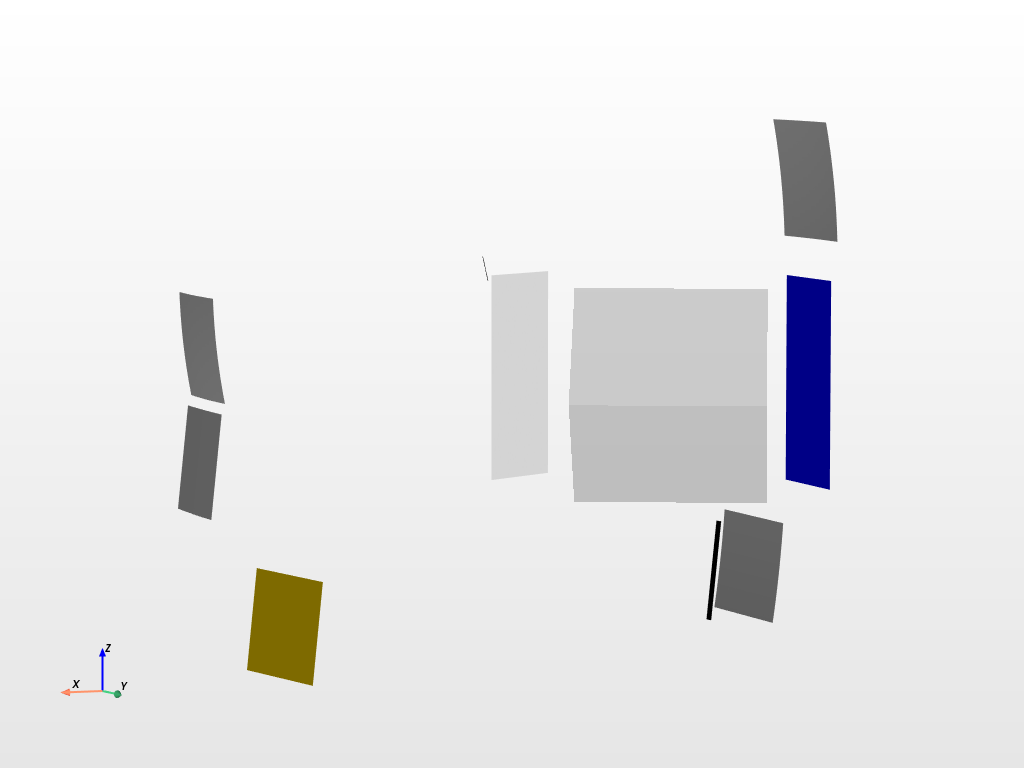

In [57]:
pl = pv.Plotter(lighting='three lights')
pl.add_mesh(telescope.get_pvobj(), color='silver')
pl.add_mesh(entrance_slit.get_pvobj(), color='black')
pl.add_mesh(collimator.get_pvobj(), color='silver')
pl.add_mesh(grating.get_pvobj(), color='blue')
pl.add_mesh(pilot_mirror.get_pvobj(), color='silver')
pl.add_mesh(roof_mirror_lower.get_pvobj(), color='silver', opacity=0.5)
pl.add_mesh(roof_mirror_upper.get_pvobj(), color='silver', opacity=0.5)
pl.add_mesh(camera.get_pvobj(), color='silver')
if use_fold_mirror or use_parabolic_cylinders:
    pl.add_mesh(fold_mirror.get_pvobj(), color='silver')
pl.add_mesh(exit_slit.get_pvobj(), color='black')
pl.add_mesh(detector.get_pvobj(), color='gold')
pl.add_axes()

pl.camera.position = [500,1000,100]#[1000, 0, 0]#
pl.camera.focal_point = [0.5*(telescope._center[0]+camera._center[0]), 0, 0.5*(telescope._center[2]+detector._center[2])]
pl.camera.up = [0,0,1]
pl.camera.zoom(3)
pl.set_background(pv.Color(np.repeat(0.9,3)), top=pv.Color(np.repeat(1.0,3)))

pl.show(jupyter_backend='static') # interactive plotting doesn't work with 'Restart and Run all cells'

In [58]:
system_bounds=np.reshape(pl.bounds,(3,2))
np.diff(system_bounds,axis=1)

array([[166.93591225],
       [113.85867691],
       [126.02479172]])

Looks good, let's put some rays through this sucker.

### Ray tracing

We need to fill the telescope aperture

In [59]:
width_rotation_mat = np.random.rand(2,3,3)
length_rotation_mat = np.random.rand(3,3,3)

width_rotation_mat_grid = add_const_axis(width_rotation_mat, 0, length_rotation_mat.shape[0])
length_rotation_mat_grid = add_const_axis(length_rotation_mat, 1, width_rotation_mat.shape[0])

field_rotation_mat = np.matmul(length_rotation_mat_grid, width_rotation_mat_grid)

In [60]:
np.matmul(field_rotation_mat, [1,0,0]).shape

(3, 2, 3)

In [61]:
width_rotation_mat_grid.shape, length_rotation_mat_grid.shape

((3, 2, 3, 3), (3, 2, 3, 3))

In [62]:
field_rotation_mat.shape

(3, 2, 3, 3)

In [63]:
np.matmul(field_rotation_mat, [1,0,0])[1,1]

array([0.78074597, 1.3030633 , 1.25154322])

In [64]:
np.matmul(np.matmul(length_rotation_mat[1], width_rotation_mat[1]), [1,0,0])

array([0.78074597, 1.3030633 , 1.25154322])

In [65]:
width_rotation_mat.shape

(2, 3, 3)

In [66]:
def get_test_rays(test_wavelength=None, test_wavelength_offset=None, 
                  fill_fraction=0.9, 
                  n_rays=101, 
                  slit_width_offset_fraction=0.0, 
                  slit_length_offset_fraction=0.0,
                  start_distance=100,
                  offset_power=1.):
    # computes test rays input across area of telescope for a range of field angles and wavelengths
    # return array has dimensions (n_waves, n_length, n_width, n_rays (across tel width), n_rays (across tel height))
    
    # figure out telescope width / height offset
    central_ray_position = telescope._center
    field_width = fill_fraction * telescope_width
    field_height = fill_fraction * telescope_width * jnp.cos(off_axis_angle_rad)
    offset_fraction_array = jnp.linspace(-1.0, 1.0, n_rays)
    offset_sign = jnp.sign(offset_fraction_array)
    offset_fraction_array = jnp.abs(offset_fraction_array)**offset_power
    offset_fraction_array = 0.5*offset_sign*offset_fraction_array

    # determine incoming field angle based on slit size
    width_rotation_mat = rotation_matrix(slit_width_offset_fraction*slit_angular_width_rad/2., jnp.array([0,0,1]))
    length_rotation_mat = rotation_matrix(slit_length_offset_fraction*slit_length_rad/2., jnp.array([0,1,0]))
    
    if width_rotation_mat.shape == (3,3):
        width_rotation_mat = jnp.array([width_rotation_mat])
    if length_rotation_mat.shape == (3,3):
        length_rotation_mat = jnp.array([length_rotation_mat])
    
    width_rotation_mat_grid = add_const_axis(width_rotation_mat, 0, length_rotation_mat.shape[0])
    length_rotation_mat_grid = add_const_axis(length_rotation_mat, 1, width_rotation_mat.shape[0])
    
    field_rotation_mat = jnp.matmul(length_rotation_mat_grid, width_rotation_mat_grid)
    incoming_ray_vec = jnp.matmul(field_rotation_mat, jnp.array([-1,0,0]))
    
    # determine mirror intersection positions
    ray_dz, ray_dy = jnp.meshgrid(offset_fraction_array, offset_fraction_array)
    # ^^^^^^^^^^^ order here puts -2 dimension along telescope width with telescope vdir as described above
    mirror_positions = (central_ray_position
                        +field_width*const_to_vec3(ray_dy)*jnp.array([0,1,0])
                        +field_height*const_to_vec3(ray_dz)*jnp.array([0,0,1]))
    mirror_positions = add_const_axis(mirror_positions, 0, incoming_ray_vec.shape[0])
    mirror_positions = add_const_axis(mirror_positions, 1, incoming_ray_vec.shape[1])
    
    # aim all rays along input vector
    ray_directions = incoming_ray_vec
    ray_directions = add_const_axis(ray_directions, 2, mirror_positions.shape[-3])
    ray_directions = add_const_axis(ray_directions, 3, mirror_positions.shape[-2])    
    
    # detemine ray origins
    ray_offset = -ray_directions*start_distance
    ray_origins = mirror_positions + ray_offset

    # determine wavelength
    if test_wavelength is None:
        if test_wavelength_offset is None:
            raise ValueError('Please set one of test_wavelength or test_wavelength_offset.')
        test_wavelength = (heterodyne_wavelength 
                           + jnp.array(test_wavelength_offset)*minimum_resolvable_wavelength_difference)
        
    test_wavelength = jnp.array(test_wavelength)
    if test_wavelength.shape == ():
        test_wavelength = jnp.array([test_wavelength])

    ray_origins = add_const_axis(ray_origins, 0, test_wavelength.shape[0])
    ray_directions = add_const_axis(ray_directions, 0, test_wavelength.shape[0])
        
    test_wavelength = add_const_axis(test_wavelength, 1, ray_origins.shape[1])
    test_wavelength = add_const_axis(test_wavelength, 2, ray_origins.shape[2])
    test_wavelength = add_const_axis(test_wavelength, 3, ray_origins.shape[3])
    test_wavelength = add_const_axis(test_wavelength, 4, ray_origins.shape[4])
    
    # remove extraneous axes
    ray_origins = np.squeeze(ray_origins)
    ray_directions = np.squeeze(ray_directions)
    test_wavelength = np.squeeze(test_wavelength)

    test_rays = Rays(origins=ray_origins, 
                     directions=ray_directions, 
                     wavelengths=test_wavelength)
    
    return test_rays

In [67]:
n_rays = 11
fill_fraction = 0.9
slit_width_offset_fraction = 0.0
slit_length_offset_fraction = 0.0

heterodyne_rays = get_test_rays(test_wavelength=heterodyne_wavelength, 
                                n_rays=n_rays, 
                                fill_fraction=fill_fraction,
                                slit_length_offset_fraction=slit_length_offset_fraction,
                                slit_width_offset_fraction=slit_width_offset_fraction)

test_wavelength_offset = 256
test_wavelength = (heterodyne_wavelength 
                   + test_wavelength_offset*minimum_resolvable_wavelength_difference)
test_rays = get_test_rays(test_wavelength=test_wavelength, 
                          n_rays=n_rays, 
                          fill_fraction=fill_fraction,
                          slit_length_offset_fraction=slit_length_offset_fraction,
                          slit_width_offset_fraction=slit_width_offset_fraction)

In [68]:
test_rays.shape

(11, 11)

Before we lay out the system we need to know spatial focal lengths for the components, which requires defining the telescope and collimator

In [69]:
def system_trace(rays, optics_operations):
    output_rays = [rays.nancopy() for i in range(len(optics_operations)+1)]
    output_rays[0] = rays
    
    vecs = jnp.empty((len(optics_operations),)+rays.origins.shape)
    dist = jnp.empty((len(optics_operations),)+rays.origins.shape[:-1])
    
    for i_opt, opt_op in enumerate(optics_operations):
        if len(opt_op)==3:
            optic, operation, options = opt_op
        else:
            optic, operation = opt_op
            options = dict()

        output_rays[i_opt+1] = getattr(optic, operation)(output_rays[i_opt], **options)
        
        vecs = vecs.at[i_opt].set(output_rays[i_opt+1].origins - output_rays[i_opt].origins)
        dist = dist.at[i_opt].set(vec_array_norm(vecs[i_opt]))
    
    return output_rays, vecs, dist

In [70]:
path1 = [[telescope, 'reflect'],
         [entrance_slit, 'pass_through'],
         [collimator, 'reflect'],
         [grating, 'diffract', dict(order=-1)],
         [pilot_mirror, 'reflect'],
         [roof_mirror_upper, 'reflect'],
         [roof_mirror_lower, 'reflect'],
         [grating, 'diffract', dict(order=1)],
         [camera, 'reflect'],
         [exit_slit, 'reflect' if use_reflective_exit_slit else 'pass_through'],
         [detector, 'detect']]
path2 = [[telescope, 'reflect'],
         [entrance_slit, 'pass_through'],
         [collimator, 'reflect'],
         [grating, 'diffract', dict(order=1)],
         [roof_mirror_upper, 'reflect'],
         [roof_mirror_lower, 'reflect'],
         [pilot_mirror, 'reflect'],
         [grating, 'diffract', dict(order=-1)],
         [camera, 'reflect'],
         [exit_slit, 'reflect' if use_reflective_exit_slit else 'pass_through'],       
         [detector, 'detect']]

if use_fold_mirror or use_parabolic_cylinders:
    path1.insert(-2,[fold_mirror, 'reflect'])
    path2.insert(-2,[fold_mirror, 'reflect'])
    
output_rays_path1, vecs_path1, dist_path1 = system_trace(test_rays, path1)
output_rays_path2, vecs_path2, dist_path2 = system_trace(test_rays, path2)

In [71]:
def pv_ray_plot(plotter, rays, dist=10., rayskip=1):
    it_p0, it_d0 = np.reshape([rays.origins, 
                               rays.directions], (2, -1, 3))[:,::rayskip,:]
    
    for p0, d0 in it_array:
        line = pv.Line(pointa=p0, pointb=p0+dist*d0)
        plotter.add_mesh(line, color='white', line_width=2)
        
def pv_ray2ray_plot(plotter, rays0, rays1, dist=None, rayskip=1, raycolor='white'):
    if dist is None:
        dist = rays1.origins - rays0.origins
        dist = np.linalg.norm(dist, axis=-1)
        dist = np.nanmean(dist)

    flat_p0, flat_d0, flat_p1 = np.reshape(np.array([rays0.origins,
                                                     rays0.directions,
                                                     rays1.origins])[:,::rayskip, ::rayskip, :],
                                           (3,-1,3))
    
    for p0, d0, p1 in zip(flat_p0, flat_d0, flat_p1):
        if np.any(np.isnan(p1)):
            line = pv.Line(pointa=p0, pointb=p0+dist*d0)
            color = 'darkred'
        else:
            line = pv.Line(pointa=p0, pointb=p1)
            color = raycolor
        pl.add_mesh(line, color=color, line_width=2)

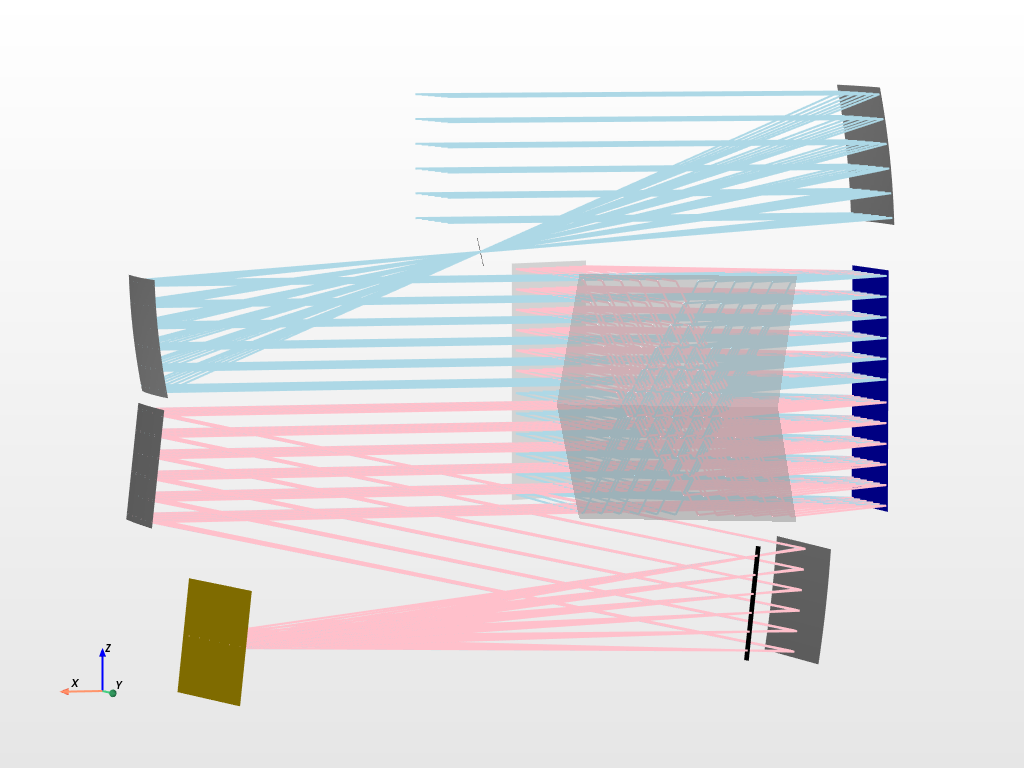

In [72]:
pl = pv.Plotter(lighting='three lights')
pl.add_mesh(telescope.get_pvobj(), color='silver')
pl.add_mesh(entrance_slit.get_pvobj(), color='black')
pl.add_mesh(collimator.get_pvobj(), color='silver')
pl.add_mesh(grating.get_pvobj(), color='blue')
pl.add_mesh(pilot_mirror.get_pvobj(), color='silver')
pl.add_mesh(roof_mirror_lower.get_pvobj(), color='silver', opacity=0.5)
pl.add_mesh(roof_mirror_upper.get_pvobj(), color='silver', opacity=0.5)
pl.add_mesh(camera.get_pvobj(), color='silver')
if use_fold_mirror or use_parabolic_cylinders:
    pl.add_mesh(fold_mirror.get_pvobj(), color='silver')
pl.add_mesh(exit_slit.get_pvobj(), color='black')
pl.add_mesh(detector.get_pvobj(), color='gold')
pl.add_axes()

rayskip = int(np.floor(np.max(test_rays.shape)/4.))

show_rays = [0,  # before telescope
             1,  # telescope-slit
             2,  # slit-collimator
             3,  # collimator-grating
             4,  # interferometer 1
             5,  # interferometer 2
             6,  # interferometer 3
             7,  # interferometer 4
             8,  # grating-camera
             -3, # camera-spectral focal plane
             -2  # focal plane - grating
            ]

if use_fold_mirror or use_parabolic_cylinders:
    show_rays.insert(-2, -4)

for i in show_rays:
    pv_ray2ray_plot(pl, 
                    output_rays_path1[i],
                    output_rays_path1[i+1],
                    rayskip=rayskip, dist=100,
                    raycolor='pink')
for i in show_rays:        
    pv_ray2ray_plot(pl, 
                    output_rays_path2[i],
                    output_rays_path2[i+1],
                    rayskip=rayskip, dist=100, 
                    raycolor='lightblue')

pl.camera.position = [500,1500,100]#[0,0,1500]#[0,1500,0]#[1000,0,0]#
pl.camera.focal_point = [0.5*(np.min([grating._center[0], detector._center[0]])+camera._center[0]), 0, 0.5*(telescope._center[2]+detector._center[2])]
pl.camera.up = [0,0,1]#[0,-1,0]#[0,-1,0]#
pl.camera.zoom(4.9)
pl.set_background(pv.Color(np.repeat(0.9,3)), top=pv.Color(np.repeat(1.0,3)))

pl.show(jupyter_backend='static') # interactive plotting doesn't work with 'Restart and Run all cells'

In [76]:
# path1 = [[telescope, 'reflect'],
#          [entrance_slit, 'pass_through'],
#          [collimator, 'reflect'],
#          [grating, 'diffract', dict(order=-1)],
#          [pilot_mirror, 'reflect'],
#          [roof_mirror_upper, 'reflect'],
#          [roof_mirror_lower, 'reflect'],
#          [grating, 'diffract', dict(order=1)],
#          [camera, 'reflect'],
#          [fold_mirror, 'reflect'],
#          [exit_slit, 'reflect' if use_reflective_exit_slit else 'pass_through'],
#          [detector, 'detect']]

[[<raytrace.OffAxisParabola at 0x7339a8737250>, 'reflect'],
 [<raytrace.Rectangle at 0x7339a8766080>, 'pass_through'],
 [<raytrace.OffAxisParabola at 0x7339a8765ea0>, 'reflect'],
 [<raytrace.PlaneGrating at 0x733a4c494b20>, 'diffract', {'order': -1}],
 [<raytrace.Rectangle at 0x7339d023f6d0>, 'reflect'],
 [<raytrace.Rectangle at 0x7339d0253cd0>, 'reflect'],
 [<raytrace.Rectangle at 0x7339d0253d30>, 'reflect'],
 [<raytrace.PlaneGrating at 0x733a4c494b20>, 'diffract', {'order': 1}],
 [<raytrace.OffAxisBiParabola at 0x7339a87372b0>, 'reflect'],
 [<raytrace.OffAxisBiParabola at 0x7339a8766830>, 'reflect'],
 [<raytrace.Rectangle at 0x7339a858d7b0>, 'pass_through'],
 [<raytrace.Rectangle at 0x7339a87f5840>, 'detect']]

In [104]:
from pprint import pprint
pprint(vars(telescope))

{'_Rmat': Array([[-0.,  1., -0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.]], dtype=float64),
 '_axis_out': Array([1., 0., 0.], dtype=float64),
 '_center': Array([ 0.        ,  0.        , 51.46169355], dtype=float64),
 '_focus': Array([89.02334538,  0.        , 31.02706974], dtype=float64),
 '_invRmat': Array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float64),
 '_normal': Array([1., 0., 0.], dtype=float64),
 '_quadratic_coef': Array(0.0027722, dtype=float64),
 '_rectangular': True,
 '_reflectivity': 1.0,
 '_s0': Array(-1.1576, dtype=float64),
 '_transmission': 0.0,
 '_u0': Array(0., dtype=float64),
 '_ubounds': Array([-15.,  15.], dtype=float64),
 '_udir': Array([-0.,  1., -0.], dtype=float64),
 '_v0': Array(-20.43462381, dtype=float64),
 '_vbounds': Array([-15.,  15.], dtype=float64),
 '_vdir': Array([0., 0., 1.], dtype=float64),
 '_vertex': Array([-1.1576    ,  0.        , 31.02706974], dtype=float64),
 '_width': Array([30, 30], dtype=int64)}


In [96]:
pprint(vars(fold_mirror._u_parabola))

{'_Rmat': Array([[ 0.        ,  1.        , -0.        ],
       [-0.21643961,  0.        ,  0.97629601],
       [ 0.97629601, -0.        ,  0.21643961]], dtype=float64),
 '_axis_out': Array([ 0.97629601, -0.        ,  0.21643961], dtype=float64),
 '_center': Array([ 16.38077417,   0.        , -46.54465893], dtype=float64),
 '_focus': Array([941124.64973789, 338090.10679933,  -3256.80516588], dtype=float64),
 '_invRmat': Array([[ 0.        , -0.21643961,  0.97629601],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.97629601,  0.21643961]], dtype=float64),
 '_normal': Array([ 0.97629601, -0.        ,  0.21643961], dtype=float64),
 '_quadratic_coef': Array(2.6067389e-07, dtype=float64),
 '_rectangular': True,
 '_reflectivity': 1.0,
 '_s0': Array(-40947.29114397, dtype=float64),
 '_transmission': 0.0,
 '_u0': Array(338090.10679933, dtype=float64),
 '_ubounds': Array([-12.60080645,  12.60080645], dtype=float64),
 '_udir': Array([ 0.,  1., -0.], dtype=float64),
 '_v0

In [97]:
pprint(vars(fold_mirror._v_parabola))

{'_Rmat': Array([[ 0.        ,  1.        , -0.        ],
       [-0.21643961,  0.        ,  0.97629601],
       [ 0.97629601, -0.        ,  0.21643961]], dtype=float64),
 '_axis_out': Array([ 0.97629601, -0.        ,  0.21643961], dtype=float64),
 '_center': Array([ 16.38077417,   0.        , -46.54465893], dtype=float64),
 '_focus': Array([160.55759042,  51.79505569, -47.03646753], dtype=float64),
 '_invRmat': Array([[ 0.        , -0.21643961,  0.97629601],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.97629601,  0.21643961]], dtype=float64),
 '_normal': Array([ 0.97629601, -0.        ,  0.21643961], dtype=float64),
 '_quadratic_coef': Array(0.00170154, dtype=float64),
 '_rectangular': True,
 '_reflectivity': 1.0,
 '_s0': Array(-6.27308277, dtype=float64),
 '_transmission': 0.0,
 '_u0': Array(51.79505569, dtype=float64),
 '_ubounds': Array([-12.60080645,  12.60080645], dtype=float64),
 '_udir': Array([ 0.,  1., -0.], dtype=float64),
 '_v0': Array(-31.6857252

In [73]:
camera_grating_distance

163.80774169251742

In [70]:
(telescope._center[2] + telescope._width[1]/2) - (detector._center[2] - detector._width[1]/2)

DeviceArray(125.49770864, dtype=float64)

In [71]:
camera._center[0] - np.min([grating._center[0], detector._center[0]])

DeviceArray(163.80550773, dtype=float64)

In [72]:
2*(roof_mirror_lower._center[1] - pilot_mirror._center[1])

DeviceArray(159.32839428, dtype=float64)

In [73]:
def get_element_coords(rays, element):
    coords3d = element.transform_to_element(rays.origins)
    coords2d = np.transpose(np.reshape(coords3d[...,:2], (-1,2)))
    return coords2d

def plot_element_coords(rays, element, ax=None, **kwargs):
    coords2d = get_element_coords(rays, element)
    
    plobj = ax if ax is not None else plt
    plobj.plot(*coords2d, linestyle='', marker='.', **kwargs)

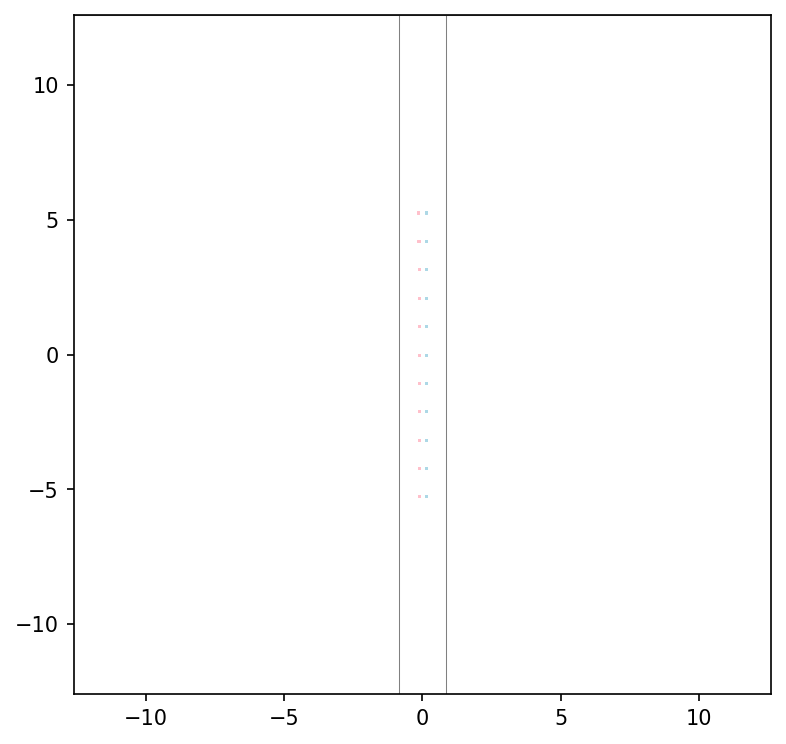

In [74]:
fig, ax = plt.subplots(1, figsize=(6,6), dpi=150)

plot_element_coords(output_rays_path1[-2], exit_slit, ax=ax, color='pink', markersize=0.75)
plot_element_coords(output_rays_path2[-2], exit_slit, ax=ax, color='lightblue', markersize=0.75)
ax.set_xlim(-exit_slit._width[1]/2, exit_slit._width[1]/2)
ax.set_ylim(-exit_slit._width[1]/2, exit_slit._width[1]/2)
ax.axvline(-exit_slit._width[0]/2, color='0.5', lw=0.5);
ax.axvline(exit_slit._width[0]/2, color='0.5', lw=0.5);
ax.axhline(-exit_slit._width[1]/2, color='0.5', lw=0.5);
ax.axhline(exit_slit._width[1]/2, color='0.5', lw=0.5);

In [75]:
1e6 / heterodyne_wavelength * np.nanmax(output_rays_path1[-2].dist_phase-output_rays_path2[-2].dist_phase)

7.910956247771589

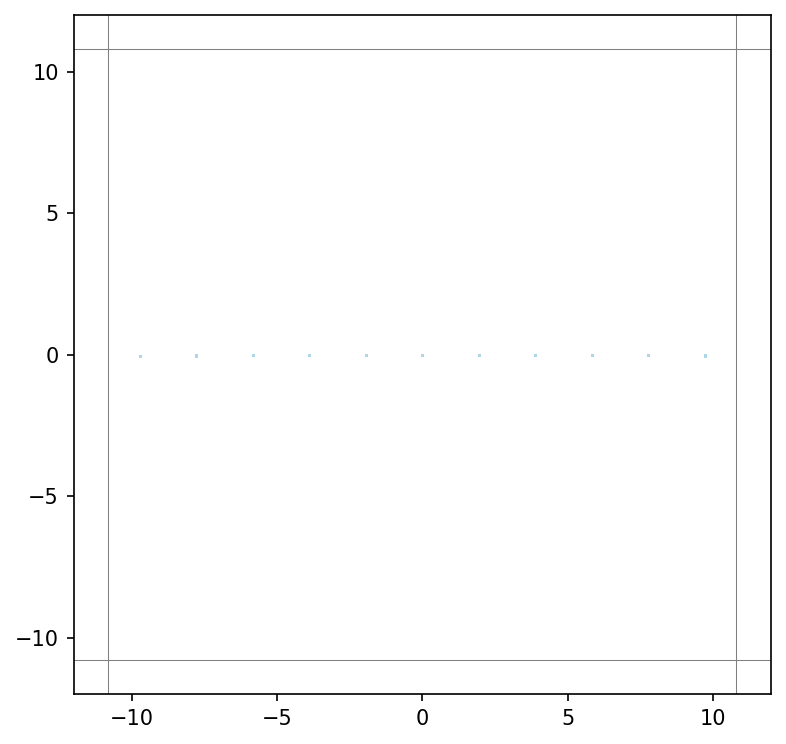

In [76]:
fig, ax = plt.subplots(1, figsize=(6,6), dpi=150)

plot_element_coords(output_rays_path1[-1], detector, ax=ax, color='pink', markersize=0.75)
plot_element_coords(output_rays_path2[-1], detector, ax=ax, color='lightblue', markersize=0.75)
ax.set_xlim(-detector_full_width/2, detector_full_width/2)
ax.set_ylim(-detector_full_width/2, detector_full_width/2);
ax.axhline(-detector_fill_fraction_spatial*detector_full_width/2, color='0.5', lw=0.5);
ax.axhline(detector_fill_fraction_spatial*detector_full_width/2, color='0.5', lw=0.5);
ax.axvline(-detector_fill_fraction_spectral*detector_full_width/2, color='0.5', lw=0.5);
ax.axvline(detector_fill_fraction_spectral*detector_full_width/2, color='0.5', lw=0.5);

# ax.set_ylim(10.68,10.78); #coordinates for slit_length_offset_fraction = 1.2

# ax.set_xlim(-9, -8.95) # coordinates for large test_wavelength_offset at slit center
# ax.set_ylim(-0.04, 0.005)

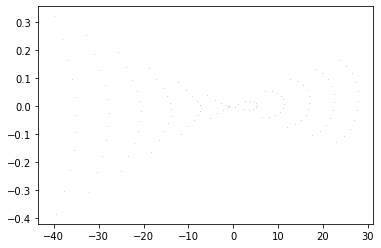

In [77]:
plt.plot(*(1e6 / heterodyne_wavelength
           *(get_element_coords(output_rays_path1[-1], detector)
             -
             get_element_coords(output_rays_path2[-1], detector))),
         linestyle='', marker='.', markersize=0.2)

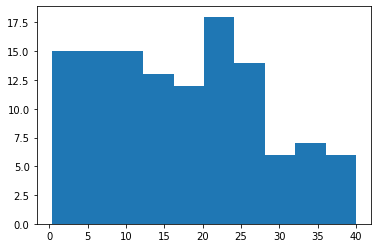

In [78]:
plt.hist(np.linalg.norm((1e6 / heterodyne_wavelength
                         *(get_element_coords(output_rays_path1[-1], detector)
                           -
                           get_element_coords(output_rays_path2[-1], detector))), axis=0));

In [79]:
# the slit is the ultimate source of light illuminating the detector, its spatial coherence is dependent on its angular size as seen from the detector
spatial_coherence_length_waves = np.float64(np.pi/2*(collimator_focal_point_dist
                                                     +collimator_grating_distance
                                                     +light_path_length_through_interferometer
                                                     +camera_grating_distance
                                                     +camera_detector_distance)/slit_width)
print(f'{spatial_coherence_length_waves = }')
spatial_coherence_length = spatial_coherence_length_waves*heterodyne_wavelength*1e-6
print(f'{spatial_coherence_length = } mm')

spatial_coherence_length_waves = 4442.3212978997735
spatial_coherence_length = 0.5400085769726964 mm


In [80]:
def path1_distance(rays):
    path1_rays, _, dist = system_trace(rays, path1)
    
    #return np.sum(dist, axis=0)
    return path1_rays[-1].dist_phase

def path2_distance(rays):
    path2_rays, _, dist = system_trace(rays, path2)
    #return np.sum(dist, axis=0)
    return path2_rays[-1].dist_phase

def get_detector_interference(rays, standard_rays=None):
    path1_rays, _, _ = system_trace(rays, path1)
    path2_rays, _, _ = system_trace(rays, path2)
    
    dist1 = path1_rays[-1].dist_phase
    dist2 = path2_rays[-1].dist_phase

    pdiff = dist1 - dist2
    
    if standard_rays is not None:
        path1_standard_rays, _, _ = system_trace(standard_rays, path1)
        path2_standard_rays, _, _ = system_trace(standard_rays, path2)
        
        dist1_standard = path1_standard_rays[-1].dist_phase
        dist2_standard = path2_standard_rays[-1].dist_phase
        
        pdiff_standard = dist1_standard - dist2_standard
        
        pdiff = pdiff - pdiff_standard
    
    p1_int = path1_rays[-1].intensities
    p2_int = path2_rays[-1].intensities
    
    combined = (p1_int
                + p2_int
                + 2*jnp.sqrt(p1_int*p2_int)*jnp.cos(2*jnp.pi/(1e-6*rays.wavelengths)*pdiff))
    
    return combined

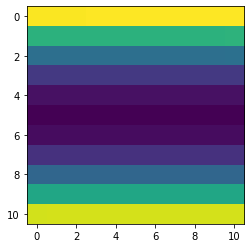

In [81]:
plt.imshow(path1_distance(test_rays))

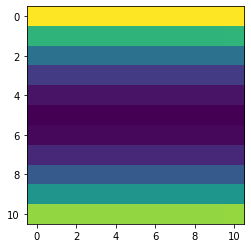

In [82]:
plt.imshow(path2_distance(test_rays))

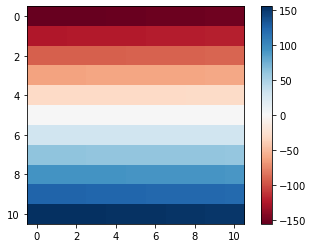

In [83]:
#opd_norm = mpl.colors.CenteredNorm(vcenter=0, halfrange=10)
plt.imshow((path1_distance(test_rays)-path2_distance(test_rays))*1e6/test_wavelength, 
           #norm=opd_norm,
           cmap='RdBu')
plt.colorbar()

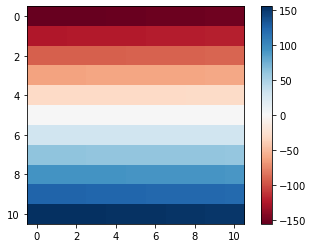

In [84]:
#opd_norm = mpl.colors.CenteredNorm(vcenter=0, halfrange=10)
plt.imshow((output_rays_path1[-1].dist_phase - output_rays_path2[-1].dist_phase)*1e6/test_wavelength, 
           #norm=opd_norm,
           cmap='RdBu')
plt.colorbar()

CPU times: user 1.91 s, sys: 3.51 ms, total: 1.91 s
Wall time: 1.89 s


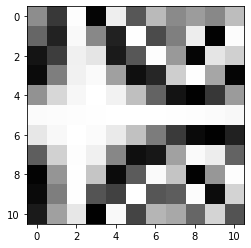

In [85]:
%%time
interference_pattern = get_detector_interference(test_rays)#, standard_rays=heterodyne_rays)
norm=mpl.colors.Normalize(vmin=0, vmax=4)
plt.imshow(interference_pattern, norm=norm, cmap='Greys_r')

In [86]:
interference_pattern.shape

(11, 11)

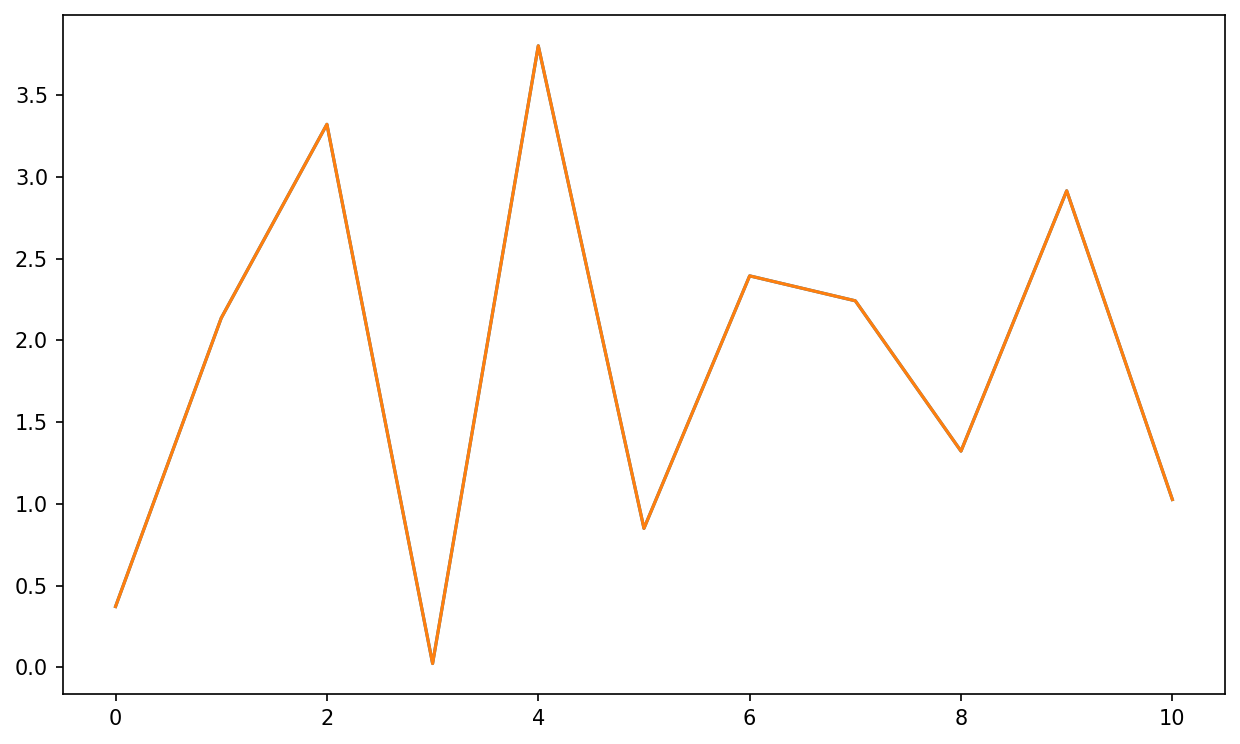

In [87]:
fig, ax = plt.subplots(1, figsize=(10,6), dpi=150)
ax.plot(interference_pattern[100]);
ax.plot(interference_pattern[105]);

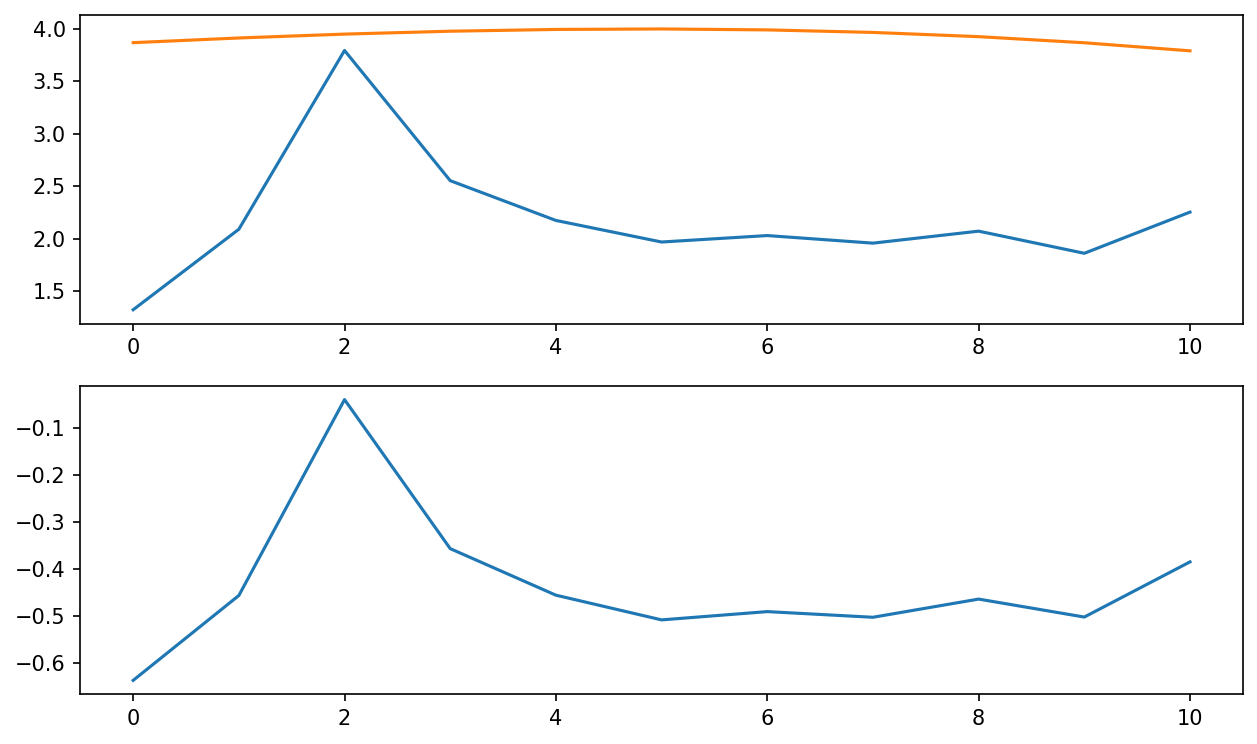

In [88]:
fig, ax = plt.subplots(nrows=2, figsize=(10,6), dpi=150)
ax[0].plot(np.mean(interference_pattern, axis=0));
ax[0].plot(interference_pattern[int(interference_pattern.shape[0]//2)]);
ax[1].plot(0.25*(np.mean(interference_pattern, axis=0)-interference_pattern[int(interference_pattern.shape[0]//2)]));

In [89]:
get_test_rays(test_wavelength=heterodyne_wavelength, 
              n_rays=n_rays).shape

(11, 11)

In [90]:
get_test_rays(test_wavelength_offset=0.0, 
              n_rays=n_rays).shape

(11, 11)

In [91]:
def get_inteferogram_for_wavelength_offset(q, n_rays=511):
    test_rays = get_test_rays(test_wavelength_offset=q, 
                              n_rays=n_rays)
    heterodyne_rays = get_test_rays(test_wavelength=heterodyne_wavelength, 
                                    n_rays=n_rays)

    return get_detector_interference(test_rays, standard_rays=None)

jit_get_inteferogram_for_wavelength_offset = jax.jit(get_inteferogram_for_wavelength_offset)

In [92]:
%%time
jit_get_inteferogram_for_wavelength_offset(0.0)

CPU times: user 11.8 s, sys: 374 ms, total: 12.2 s
Wall time: 10.7 s


DeviceArray([[4., 4., 4., ..., 4., 4., 4.],
             [4., 4., 4., ..., 4., 4., 4.],
             [4., 4., 4., ..., 4., 4., 4.],
             ...,
             [4., 4., 4., ..., 4., 4., 4.],
             [4., 4., 4., ..., 4., 4., 4.],
             [4., 4., 4., ..., 4., 4., 4.]], dtype=float64)

In [93]:
def plot_inteferogram_for_wavelength_offset(q):
    norm=mpl.colors.Normalize(vmin=0, vmax=4)
    plt.imshow(jit_get_inteferogram_for_wavelength_offset(q), norm=norm, cmap='Greys_r')

In [94]:
import ipywidgets as widgets
from ipywidgets import interactive

In [95]:
interactive(plot_inteferogram_for_wavelength_offset, q=widgets.FloatSlider(min=-15.0, max=15.0, value=1.0, step=0.5))

interactive(children=(FloatSlider(value=1.0, description='q', max=15.0, min=-15.0, step=0.5), Output()), _dom_…

## Parabolic Cylinder SHS Characterization

In [96]:
def pcyl_shs_trace(input_variables, n_rays=201, offset_power=1.0):
    wavelength_offset = input_variables[0]
    slit_width_offset = input_variables[1]
    slit_length_offset = input_variables[2]
    
    # system paths
    path1 = [[telescope, 'reflect'],
             [entrance_slit, 'pass_through'],
             [collimator, 'reflect'],
             [grating, 'diffract', dict(order=-1)],
             [pilot_mirror, 'reflect'],
             [roof_mirror_upper, 'reflect'],
             [roof_mirror_lower, 'reflect'],
             [grating, 'diffract', dict(order=1)],
             [camera, 'reflect'],
             [exit_slit, 'reflect' if use_reflective_exit_slit else 'pass_through'],
             [detector, 'detect']]
    path2 = [[telescope, 'reflect'],
             [entrance_slit, 'pass_through'],
             [collimator, 'reflect'],
             [grating, 'diffract', dict(order=1)],
             [roof_mirror_upper, 'reflect'],
             [roof_mirror_lower, 'reflect'],
             [pilot_mirror, 'reflect'],
             [grating, 'diffract', dict(order=-1)],
             [camera, 'reflect'],
             [exit_slit, 'reflect' if use_reflective_exit_slit else 'pass_through'],       
             [detector, 'detect']]

    if use_fold_mirror or use_parabolic_cylinders:
        path1.insert(-2,[fold_mirror, 'reflect'])
        path2.insert(-2,[fold_mirror, 'reflect'])
    
    # setup rays
    test_wavelength = (heterodyne_wavelength 
                       + wavelength_offset*minimum_resolvable_wavelength_difference)
    test_rays = get_test_rays(test_wavelength=test_wavelength, 
                              n_rays=n_rays, 
                              fill_fraction=fill_fraction,
                              slit_length_offset_fraction=slit_length_offset,
                              slit_width_offset_fraction=slit_width_offset, 
                              offset_power=offset_power)
    
    # traced rays
    output_rays_path1, vecs_path1, dist_path1 = system_trace(test_rays, path1)
    output_rays_path2, vecs_path2, dist_path2 = system_trace(test_rays, path2)
    
    return output_rays_path1, output_rays_path2

In [97]:
def pcyl_shs_trace_characterization(input_variables):    
    output_rays_path1, output_rays_path2 = pcyl_shs_trace(input_variables)
    
    coords2d_path1 = get_element_coords(output_rays_path1[-1], detector)
    coords2d_path2 = get_element_coords(output_rays_path2[-1], detector)
    
    opd = (output_rays_path1[-1].dist_phase - output_rays_path2[-1].dist_phase)*1e6/test_wavelength
    
    return coords2d_path1, coords2d_path2, opd

In [98]:
%%time
coords1, coords2, opd = pcyl_shs_trace_characterization([0.0, 0.0, 0.0])

CPU times: user 5.8 s, sys: 70.4 ms, total: 5.87 s
Wall time: 5.71 s


In [99]:
jit_pcyl_shs_trace_characterization = jax.jit(pcyl_shs_trace_characterization)

In [100]:
%%time
coords1, coords2, opd = jit_pcyl_shs_trace_characterization([0.0, 0.0, 0.0])

CPU times: user 9.24 s, sys: 7.46 ms, total: 9.25 s
Wall time: 9.18 s


In [101]:
def plot_pcyl_shs_characterization(wavelength_offset, 
                                   slit_width_offset, 
                                   slit_length_offset):
    coords1, coords2, opd = jit_pcyl_shs_trace_characterization([wavelength_offset, 
                                                                 slit_width_offset, 
                                                                 slit_length_offset])
    
    with plt.rc_context({"font.size": 8}): 
        fig, ((ax_coords, ax_point_offset, ax_opd, ax_interferogram),
              (ax_coords_cmap, ax_point_offset_cmap, ax_opd_cmap, ax_interferogram_cmap)) = plt.subplots(nrows=2, ncols=4, 
                                                                                                         figsize=(16,4), dpi=250,
                                                                                                         gridspec_kw={'height_ratios':[1.0, 0.1]})
        ax_coords_cmap.set_axis_off()
        ax_point_offset_cmap.set_axis_off()

        skip_coords = 2
        ax_coords.plot(*(coords1[:,::skip_coords]), linestyle='', marker='.', color='pink', markersize=0.075)
        ax_coords.plot(*(coords2[:,::skip_coords]), linestyle='', marker='.', color='lightblue', markersize=0.075)
        ax_coords.set_xlim(-detector_full_width/2, detector_full_width/2)
        ax_coords.set_ylim(-detector_full_width/2, detector_full_width/2);
        ax_coords.axhline(-detector_fill_fraction_spatial*detector_full_width/2, color='0.5', lw=0.5);
        ax_coords.axhline(detector_fill_fraction_spatial*detector_full_width/2, color='0.5', lw=0.5);
        ax_coords.axvline(-detector_fill_fraction_spectral*detector_full_width/2, color='0.5', lw=0.5);
        ax_coords.axvline(detector_fill_fraction_spectral*detector_full_width/2, color='0.5', lw=0.5);
        ax_coords.set_title('Detector Image')
        ax_coords.set_ylabel('Detector Position [mm]')
        ax_coords.set_xlabel('Detector Position [mm]')
        #ax_coords.set_ylim(-0.06,0.01)
        #ax_coords.set_ylim(np.nanmin(coords1[1]),np.nanmax(coords1[1]))
        
        ax_point_offset.plot(*(1e6 / heterodyne_wavelength
                               *(coords1[:,::skip_coords]
                                 -
                                 coords2[:,::skip_coords])),
                             linestyle='', marker='.', markersize=0.2)
        ax_point_offset.set_title('Detector Position Offset (waves)')
        ax_point_offset.set_ylabel('Position Offset [λ]')
        ax_point_offset.set_xlabel('Position Offset [λ]')
        
        opd_norm = mpl.colors.CenteredNorm()
        im_opd = ax_opd.imshow(opd, norm=opd_norm, cmap='RdBu', aspect='auto')
        fig.colorbar(im_opd, cax=ax_opd_cmap, orientation='horizontal')
        ax_opd.set_xticks([])
        ax_opd.set_yticks([])
        ax_opd.set_title('Beam Optical Path')
        ax_opd_cmap.set_xlabel('Optical Path Difference / λ')

        interferogram = 1 + 1*jnp.cos(2*jnp.pi*opd)
        inorm=mpl.colors.Normalize(vmin=0, vmax=2)
        im_interferogram = ax_interferogram.imshow(interferogram, norm=inorm, cmap='Greys_r', aspect='auto')
        ax_interferogram.set_xticks([])
        ax_interferogram.set_yticks([])
        fig.colorbar(im_interferogram, cax=ax_interferogram_cmap, orientation='horizontal')
        ax_interferogram.set_title('Beam Interferogram')
        ax_interferogram_cmap.set_xlabel('Brightness / Input')

In [102]:
import ipywidgets as widgets
from ipywidgets import interactive

In [103]:
layout = widgets.Layout(width='600px', height='40px')
def relative_slider(val, fmin=0.9, fmax=1.1, ffrac=0.01):
    return widgets.FloatSlider(min=fmin*val, 
                               max=fmax*val, 
                               value=val, 
                               step=ffrac*val,
                               layout=layout,
                               style={'description_width': '200px'})

def symmetric_slider(scale, step):
    return widgets.FloatSlider(min=-scale,
                               max=scale*1.001,
                               value=0.0,
                               step=step,                               
                               layout=layout,
                               style={'description_width': '200px'})

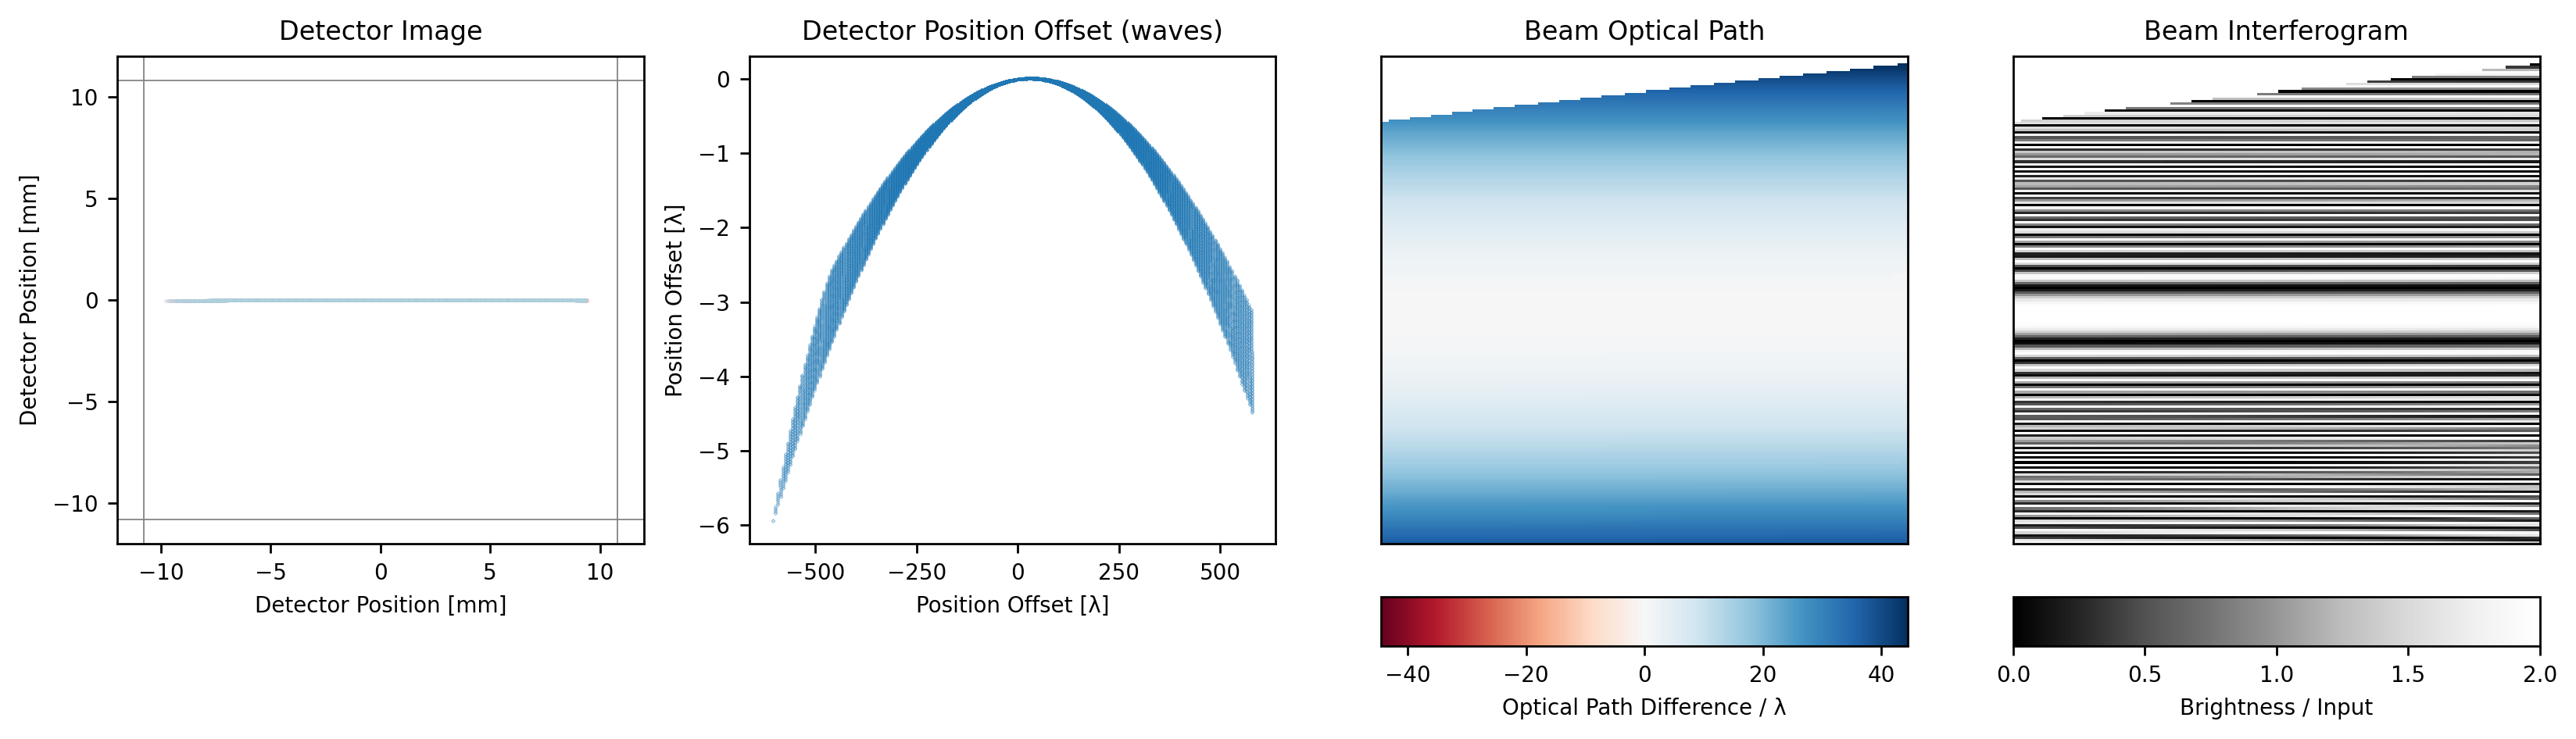

In [104]:
plot_pcyl_shs_characterization(0.0, 0.9, 0.0)

In [105]:
interactive(plot_pcyl_shs_characterization,
            wavelength_offset=symmetric_slider(16, 1.0),
            slit_width_offset=symmetric_slider(1.0, 0.05),
            slit_length_offset=symmetric_slider(1.0, 0.1))

interactive(children=(FloatSlider(value=0.0, description='wavelength_offset', layout=Layout(height='40px', wid…

## Detector position / OPL interpolation

In [106]:
n_wave_interp = 11
n_length_interp = 11
n_width_interp = 11

n_telescope_interp = 21

#wavelength_offset_array = np.linspace(-detector_full_pixel_format, detector_full_pixel_format, n_wave_interp)
wavelength_offset_array = np.linspace(-20,20,n_wave_interp)

interp_rays = get_test_rays(test_wavelength_offset=wavelength_offset_array, 
                            n_rays=n_telescope_interp, 
                            fill_fraction=fill_fraction,
                            slit_length_offset_fraction=np.linspace(-1,1,n_length_interp),
                            slit_width_offset_fraction=np.linspace(-1,1,n_width_interp))

In [107]:
%%time
system_interp_rays_path1, _, _ = system_trace(interp_rays, path1)
system_interp_rays_path2, _, _ = system_trace(interp_rays, path2)

CPU times: user 17.1 s, sys: 3.19 s, total: 20.3 s
Wall time: 13.5 s


In [108]:
path1_dist = system_interp_rays_path1[-1].dist_phase
path2_dist = system_interp_rays_path2[-1].dist_phase

path1_det_coords = detector.detector_coords(system_interp_rays_path1[-2])
path1_det_x = path1_det_coords[..., 0]
path1_det_y = path1_det_coords[..., 1]

path2_det_coords = detector.detector_coords(system_interp_rays_path2[-2])
path2_det_x = path2_det_coords[..., 0]
path2_det_y = path2_det_coords[..., 1]

(array([11917., 28854., 41307., 48315., 66518., 51249., 40259., 29837.,
        17427.,  3589.]),
 array([1142.18337903, 1142.42629442, 1142.66920982, 1142.91212522,
        1143.15504061, 1143.39795601, 1143.6408714 , 1143.8837868 ,
        1144.1267022 , 1144.36961759, 1144.61253299]),
 <BarContainer object of 10 artists>)

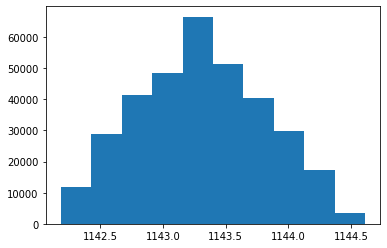

In [109]:
plt.hist(np.ravel(path1_dist))

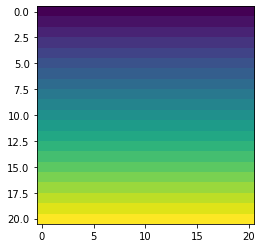

In [110]:
plt.imshow(path1_det_x[5,5,5,:,:])

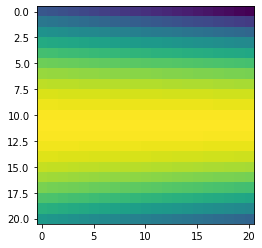

In [111]:
plt.imshow(path1_det_y[5,5,5,:,:])

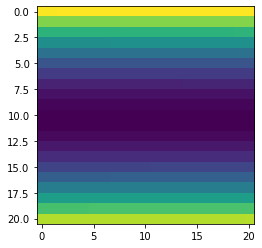

In [112]:
plt.imshow(path1_dist[5,5,5,:,:])

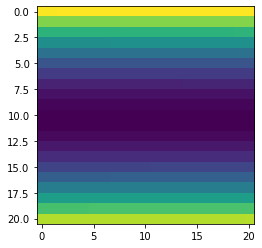

In [113]:
plt.imshow(path2_dist[5,5,5,:,:])

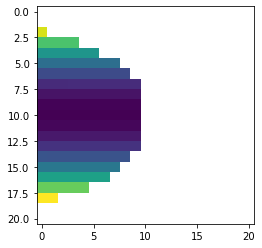

In [114]:
testarr = path2_dist[5,5,0]
plt.imshow(testarr)

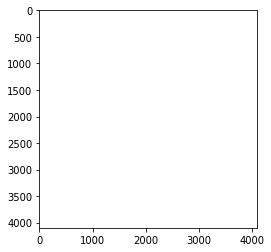

In [115]:
t1 = jax.image.resize(testarr[:,:], (4097, 4097), "bilinear")
plt.imshow(t1)

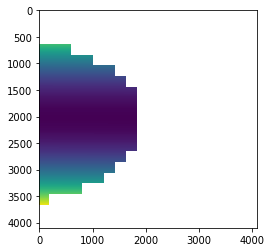

In [116]:
import jax.scipy as jscipy

n_telescope_interp = testarr.shape[0]
#print(f'{n_telescope_interp=}')

n_det_interp_pts = 4097
det_interp_coords_rel = jnp.linspace(0, n_telescope_interp-1, n_det_interp_pts)

det_interp_coords_rel_2d_x, det_interp_coords_rel_2d_y = jnp.meshgrid(det_interp_coords_rel, det_interp_coords_rel)

t2 = jscipy.ndimage.map_coordinates(np.transpose(testarr), [det_interp_coords_rel_2d_x, det_interp_coords_rel_2d_y], order=1)
plt.imshow(t2)

In [117]:
t1.shape

(4097, 4097)

In [118]:
t2.shape

(4097, 4097)

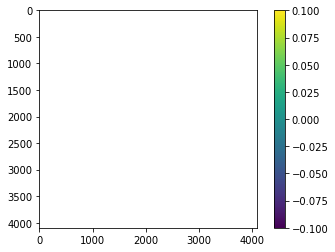

In [119]:
plt.imshow((t1-t2)/t2)
plt.colorbar()

In [120]:
def nanresize(arr, interp_size):
    
    arr_size = arr.shape[0]
    interp_coords_rel = jnp.linspace(0, arr_size-1., interp_size)
    interp_coords_rel_2d_x, interp_coords_rel_2d_y = jnp.meshgrid(interp_coords_rel, interp_coords_rel)

    arr_interp = jscipy.ndimage.map_coordinates(arr, 
                                                [interp_coords_rel_2d_y, interp_coords_rel_2d_x], 
                                                order=1, 
                                                mode='reflect')

    return arr_interp

In [121]:
t3 = nanresize(testarr, 4097)

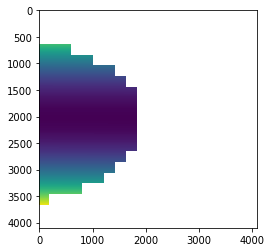

In [122]:
plt.imshow(t3)

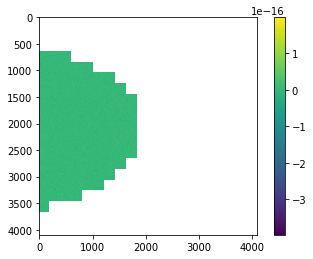

In [123]:
plt.imshow((t3-t2)/t2)
plt.colorbar()

In [124]:
2**12+1

4097

In [125]:
def nanresize_centers(arr, size):
    
    resized_corners = nanresize(arr, size+1)
    
    resized_centers = jnp.mean(jnp.array([resized_corners[ :-1,  :-1], 
                                          resized_corners[1:  ,  :-1], 
                                          resized_corners[1:  , 1:  ], 
                                          resized_corners[ :-1, 1:  ]]), axis=0)

    return resized_centers

In [126]:
def hist2d_quantity(x, y, q=None, bins=1, bin_counts=None, nonan=True):
    if bin_counts is None:
        bin_counts = jnp.histogram2d(jnp.ravel(x),
                                     jnp.ravel(y), 
                                     bins=bins)[0]
    if q is None:
        return bin_counts

    if nonan:
        q_to_use = jnp.where(jnp.isnan(q), 0.0, q)
    else:
        q_to_use = q
    
    bin_q_sum = jnp.histogram2d(jnp.ravel(x), 
                                jnp.ravel(y), 
                                bins=bins,
                                weights=jnp.ravel(q_to_use), 
                                density=False)[0]

    return bin_q_sum / bin_counts

In [127]:
default_detector_npix = 256

In [128]:
def get_beam_brightness_and_centroid(p1x, p1y, p1d, 
                                     p2x, p2y, p2d):
    # interpolate beam grids
    n_beam_interp_pts = default_detector_npix * 40 # ensure enough points per pixel that computed brightness is smooth, if god is good

    p1_x_interp = nanresize_centers(p1x, n_beam_interp_pts)
    p1_y_interp = nanresize_centers(p1y, n_beam_interp_pts)
    p1_d_interp = nanresize_centers(p1d, n_beam_interp_pts)
    p1_xy_interp = jnp.moveaxis(jnp.array([p1_x_interp, p1_y_interp]), 0, -1)

    p2_x_interp = nanresize_centers(p2x, n_beam_interp_pts)
    p2_y_interp = nanresize_centers(p2y, n_beam_interp_pts)
    p2_d_interp = nanresize_centers(p2d, n_beam_interp_pts)
    p2_xy_interp = jnp.moveaxis(jnp.array([p2_x_interp, p2_y_interp]), 0, -1)

    # construct detector pixel grid
    n_det_grid_points = default_detector_npix
    detector_grid_1d = jnp.linspace(-detector_full_width/2., detector_full_width/2., n_det_grid_points+1)
    detector_grid_1d += 0.5*(detector_grid_1d[1] - detector_grid_1d[0])
    detector_grid_x, detector_grid_y = jnp.meshgrid(detector_grid_1d, detector_grid_1d)

    # determine beam intensities in each pixel
    p1_n_rays = hist2d_quantity(p1_x_interp, 
                                p1_y_interp, 
                                bins=detector_grid_1d)
    p1_int = p1_n_rays/n_beam_interp_pts**2

    p2_n_rays = hist2d_quantity(p2_x_interp,
                                p2_y_interp,
                                bins=detector_grid_1d)
    p2_int = p2_n_rays/n_beam_interp_pts**2

    # determine centroid of all light that falls in each pixel
    pix_x_centroid = hist2d_quantity(jnp.concatenate([jnp.ravel(p1_x_interp), jnp.ravel(p2_x_interp)]),
                                     jnp.concatenate([jnp.ravel(p1_y_interp), jnp.ravel(p2_y_interp)]),
                                     q=jnp.concatenate([jnp.ravel(p1_x_interp), jnp.ravel(p2_x_interp)]),
                                     bins=detector_grid_1d)
    pix_y_centroid = hist2d_quantity(jnp.concatenate([jnp.ravel(p1_x_interp), jnp.ravel(p2_x_interp)]),
                                     jnp.concatenate([jnp.ravel(p1_y_interp), jnp.ravel(p2_y_interp)]),
                                     q=jnp.concatenate([jnp.ravel(p1_y_interp), jnp.ravel(p2_y_interp)]),
                                     bins=detector_grid_1d)
    
    return (p1_int, p2_int, 
            detector_grid_x, detector_grid_y,
            pix_x_centroid, pix_y_centroid)

In [173]:
def get_detector_interp_quantities(wavelength_offset, 
                                   slit_width_offset, 
                                   slit_length_offset):
    
    wavelength = (heterodyne_wavelength
                  + wavelength_offset*minimum_resolvable_wavelength_difference)
    
    output_rays_path1, output_rays_path2 = pcyl_shs_trace([wavelength_offset, 
                                                           slit_width_offset, 
                                                           slit_length_offset], 
                                                          n_rays=1281)
    
    p1d = output_rays_path1[-1].dist_phase
    p2d = output_rays_path2[-1].dist_phase
    
    def get_detector_coords(rays):
        coords3d = detector.transform_to_element(rays.origins)
        coords2d = np.moveaxis(coords3d[..., :2], -1, 0)
        return coords2d
    
    p1x, p1y = get_detector_coords(output_rays_path1[-1])
    p2x, p2y = get_detector_coords(output_rays_path2[-1])   
    
    (p1i, p2i, 
     detector_grid_x, detector_grid_y,
     pix_x_centroid, pix_y_centroid) = get_beam_brightness_and_centroid(p1x, p1y, p1d, 
                                                                        p2x, p2y, p2d)
    
    return (p1x, p1y, p1d, p1i,
            p2x, p2y, p2d, p2i,
            detector_grid_x, detector_grid_y,
            pix_x_centroid, pix_y_centroid)

In [174]:
jit_get_detector_interp_quantities = jax.jit(get_detector_interp_quantities)

In [175]:
%%time
(p1x, p1y, p1d, p1i,
 p2x, p2y, p2d, p2i,
 detector_grid_x, detector_grid_y,
 pix_x_centroid, pix_y_centroid) = jit_get_detector_interp_quantities(0.0, 0.0, 0.0)

CPU times: user 3min 8s, sys: 14.4 s, total: 3min 23s
Wall time: 59.4 s


In [176]:
p1x.shape

(1281, 1281)

In [177]:
pix_xy_centroid = np.reshape(np.moveaxis([pix_x_centroid, pix_y_centroid], 0, -1), (-1, 2))
pix_xy_centroid_isnan = np.any(np.isnan(pix_xy_centroid), axis=1)
pix_xy_centroid_nonan = pix_xy_centroid[np.logical_not(pix_xy_centroid_isnan)]

In [186]:
import scipy

def interp_rays_to_centroid(path_x, path_y, path_d,
                            pix_x_centroid, pix_y_centroid):
    
    pix_xy_centroid = np.reshape(np.moveaxis([pix_x_centroid, pix_y_centroid], 0, -1), (-1, 2))
    pix_xy_centroid_isnan = np.any(np.isnan(pix_xy_centroid), axis=1)
    pix_xy_centroid_nonan = pix_xy_centroid[np.logical_not(pix_xy_centroid_isnan)]
    pix_x_centroid_nonan, pix_y_centroid_nonan = np.transpose(pix_xy_centroid_nonan)
    
    path_coords = np.reshape(np.moveaxis([path_x, path_y, path_d], 0, -1), (-1, 3))
    path_coords_isnan = np.any(np.isnan(path_coords), axis=1)
    path_coords_nonan = path_coords[np.logical_not(path_coords_isnan)]
    path_x_nonan, path_y_nonan, path_d_nonan = np.transpose(path_coords_nonan)
    
    path_centroid_interp_dist =scipy.interpolate.griddata((path_x_nonan, path_y_nonan), path_d_nonan,
                                                          (pix_x_centroid_nonan, pix_y_centroid_nonan))
    path_interp_dist = np.full_like(pix_xy_centroid_isnan*1., np.nan)
    path_interp_dist[np.logical_not(pix_xy_centroid_isnan)] = path_centroid_interp_dist
    path_interp_dist = np.reshape(path_interp_dist, (default_detector_npix, default_detector_npix))
    
    return path_interp_dist

In [187]:
%%time
interp_rays_to_centroid(p1x, p1y, p1d,
                        pix_x_centroid, pix_y_centroid)

CPU times: user 29 s, sys: 6.05 s, total: 35.1 s
Wall time: 26.1 s


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [188]:
import scipy

def get_detector_image(wavelength_offset, 
                       slit_width_offset, 
                       slit_length_offset):
    
    (p1x, p1y, p1d, p1i,
     p2x, p2y, p2d, p2i,
     detector_grid_x, detector_grid_y,
     pix_x_centroid, pix_y_centroid) = jit_get_detector_interp_quantities(wavelength_offset, 
                                                                          slit_width_offset, 
                                                                          slit_length_offset)
    
    # interp path lengths to detector grid
    p1_pix_d = interp_rays_to_centroid(p1x, p1y, p1d,
                                       pix_x_centroid, pix_y_centroid)
    p2_pix_d = interp_rays_to_centroid(p2x, p2y, p2d,
                                       pix_x_centroid, pix_y_centroid)
    
    # # nudge path lengths to detector grid
    # p1_pix_d = nudge_rays_to_centroid(p1x, p1y, p1d,
    #                                   pix_x_centroid, pix_y_centroid)
    # p2_pix_d = nudge_rays_to_centroid(p2x, p2y, p2d,
    #                                   pix_x_centroid, pix_y_centroid)
    
    # construct interfered image
    wavelength = (heterodyne_wavelength
                  + wavelength_offset*minimum_resolvable_wavelength_difference)
    phase = 2*jnp.pi/(1e-6*wavelength)*(p1_pix_d - p2_pix_d)
    both_paths = jnp.logical_and(p1i > 0., p2i > 0.)
    detector_total_brightness = jnp.where(both_paths, 
                                          p1i + p2i + 2*jnp.sqrt(p1i*p2i)*jnp.cos(phase),
                                          p1i + p2i)
    
    return detector_grid_x, detector_grid_y, detector_total_brightness  

In [192]:
%%time
detector_grid_x, detector_grid_y, detector_total_brightness = get_detector_image(0.0, 0.0, 0.75)

CPU times: user 3min 38s, sys: 23.9 s, total: 4min 1s
Wall time: 1min 19s


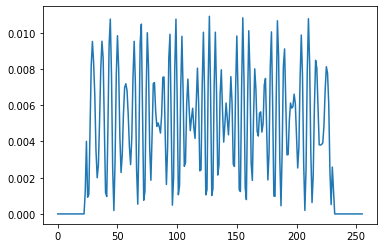

In [193]:
test_data = np.sum(detector_total_brightness, axis=1)
#test_data = test_data[30:-30]
#test_data = (test_data / np.mean(test_data) - 1)
plt.plot(test_data)

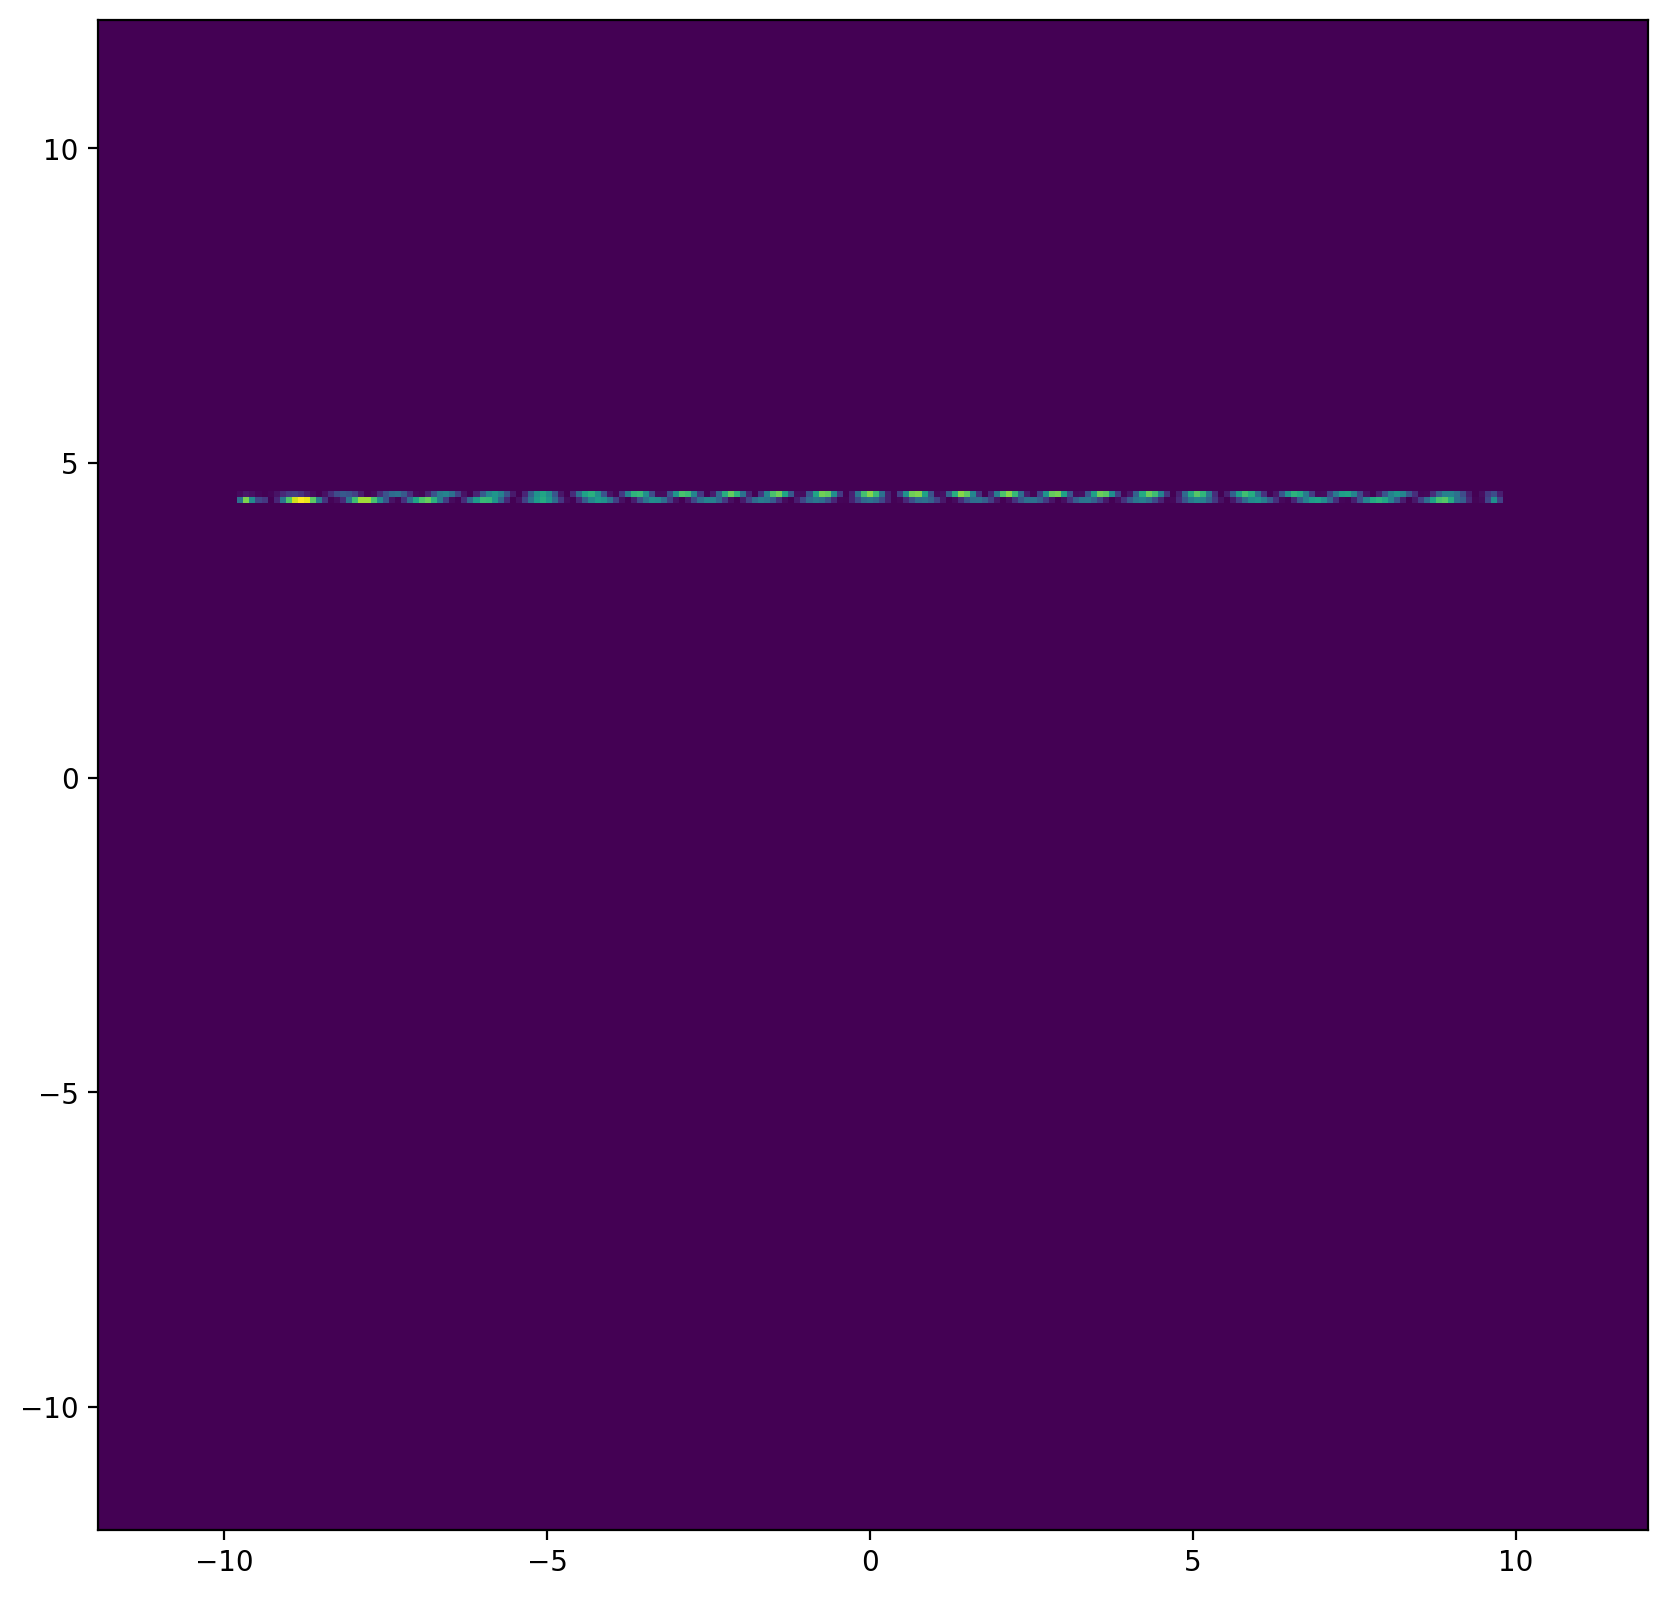

In [191]:
plt.subplots(figsize=(10,10), dpi=200)
plt.pcolormesh(detector_grid_y, detector_grid_x, detector_total_brightness)

In [209]:
def get_detector_pdist(wavelength_offset, 
                       slit_width_offset, 
                       slit_length_offset, 
                       n_rays=201):
    
    wavelength = (heterodyne_wavelength 
                  + wavelength_offset*minimum_resolvable_wavelength_difference)
    
    output_rays_path1, output_rays_path2 = pcyl_shs_trace([wavelength_offset, 
                                                           slit_width_offset, 
                                                           slit_length_offset], 
                                                          n_rays=n_rays)
    
    path1_dist = output_rays_path1[-1].dist_phase
    path2_dist = output_rays_path2[-1].dist_phase
    
    def get_detector_coords(rays):
        coords3d = detector.transform_to_element(rays.origins)
        coords2d = np.moveaxis(coords3d[..., :2], -1, 0)
        return coords2d
    
    path1_det_x, path1_det_y = get_detector_coords(output_rays_path1[-1])
    path2_det_x, path2_det_y = get_detector_coords(output_rays_path2[-1])   
    
    return (path1_det_x, path1_det_y, path1_dist,
            path2_det_x, path2_det_y, path2_dist)

In [210]:
jit_get_detector_pdist = jax.jit(get_detector_pdist)

In [211]:
%%time
(p1x, p1y, p1d, p2x, p2y, p2d) = jit_get_detector_pdist(0, 0.0, 0.0)

CPU times: user 7.48 s, sys: 40.7 ms, total: 7.52 s
Wall time: 7.42 s


In [323]:
n_det_pix = 2**12 # 2^12 = 4096
print(f'{n_det_pix = }')
det_pix_edges_mm = jnp.linspace(-detector_full_width/2., detector_full_width/2., n_det_pix+1)
det_pix_center_mm = 0.5*(det_pix_edges_mm[:-1] + det_pix_edges_mm[1:])

det_pix_edges_mm_2d_x, det_pix_edges_mm_2d_y = jnp.meshgrid(det_pix_edges_mm, det_pix_edges_mm)
det_pix_center_mm_2d_x, det_pix_center_mm_2d_y = jnp.meshgrid(det_pix_center_mm, det_pix_center_mm)

n_det_pix = 4096


In [326]:
det_pix_center_mm_2d_x.shape

(4096, 4096)

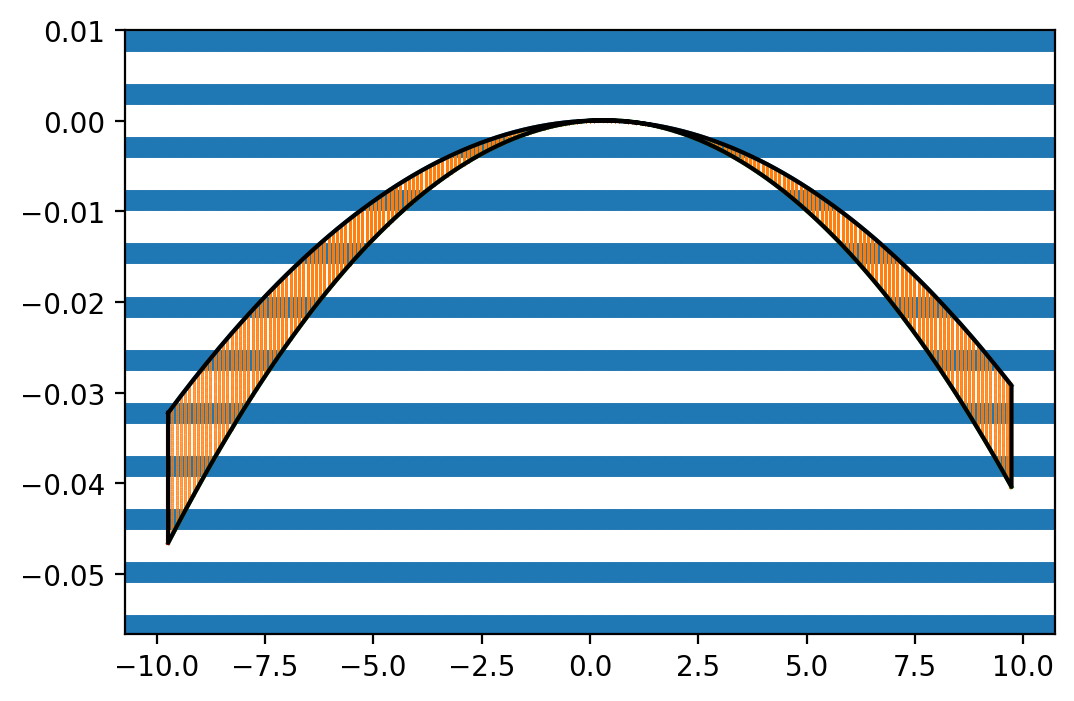

In [347]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200)

ax.scatter(np.ravel(det_pix_center_mm_2d_x), 
           np.ravel(det_pix_center_mm_2d_y))
ax.scatter(np.ravel(p1x), np.ravel(p1y), s=0.01)
ax.set_xlim(np.min(p1x)-1, np.max(p1x)+1)
ax.set_ylim(np.min(p1y)-0.01, np.max(p1y)+0.01)

edge0 = np.transpose([p1x[:,0], p1y[:,0]])
edge1 = np.transpose([p1x[-1,:], p1y[-1,:]])
edge2 = np.transpose([p1x[:,-1], p1y[:,-1]])
edge3 = np.transpose([p1x[0,:], p1y[0,:]])
boundary = np.concatenate([edge0, 
                           edge1[1:], 
                           np.flip(edge2, axis=0)[1:], 
                           np.flip(edge3, axis=0)[1:]])

ax.plot(*np.transpose(edge0))
ax.plot(*np.transpose(edge1))
ax.plot(*np.transpose(edge2))
ax.plot(*np.transpose(edge3))
ax.plot(*np.transpose(boundary), color='k')

In [351]:
boundary_poly = Polygon(boundary)

In [356]:
detPoints = list(map(Point, np.transpose([np.ravel(p1x), np.ravel(p1y)])))

In [358]:
np.sqrt(len(detPoints))

201.0

In [388]:
def test_within(poly, point):
    return (poly.intersects(point) or poly.contains(point))

In [389]:
test_within(boundary_poly, detPoints[0])

True

In [390]:
point_in_boundary_q = list(map(lambda pt: test_within(boundary_poly, pt), detPoints))

In [398]:
point_poly_dist = list(map(lambda pt: boundary_poly.distance(pt), detPoints))

In [399]:
np.max(point_poly_dist)

5.399223438085231e-13

In [370]:
boundary_poly.contains(detPoints[0])

False

In [290]:
p1d_interp_out = scipy.interpolate.griddata((np.ravel(p1x), np.ravel(p1y)),
                                            np.ravel(p1d),
                                            (np.ravel(det_pix_center_mm_2d_x),
                                             np.ravel(det_pix_center_mm_2d_y)))
p1d_interp_out = np.reshape(p1d_interp_out, (n_det_pix, n_det_pix))

In [291]:
np.sum(np.isnan(p1d_interp_out))

268133586

In [292]:
ax.imshow

<bound method Axes.imshow of <AxesSubplot:>>

In [301]:
nonan_indices_y, nonan_indices_x = np.where(np.logical_not(np.isnan(p1d_interp_out)))
nonan_bounds_x = [np.min(nonan_indices_x), np.max(nonan_indices_x)]
nonan_bounds_y = [np.min(nonan_indices_y), np.max(nonan_indices_y)]

In [302]:
nonan_bounds_x

[1547, 14834]

In [303]:
nonan_bounds_y

[8160, 8191]

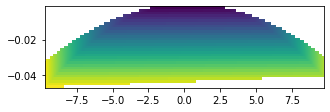

In [308]:
fig, ax = plt.subplots(1, figsize=(5, 1.5))

ax.pcolormesh(det_pix_edges_mm_2d_x[nonan_bounds_y[0]:nonan_bounds_y[1]+1,
                                    nonan_bounds_x[0]:nonan_bounds_x[1]+1],
              det_pix_edges_mm_2d_y[nonan_bounds_y[0]:nonan_bounds_y[1]+1,
                                    nonan_bounds_x[0]:nonan_bounds_x[1]+1],
              p1d_interp_out[nonan_bounds_y[0]:nonan_bounds_y[1],
                             nonan_bounds_x[0]:nonan_bounds_x[1]])
#plt.xlim(np.min(p1x)-1, np.max(p1x)+1)
#plt.ylim(np.min(p1y)-0.01, np.max(p1y)+0.01)

In [129]:
interp_pdist = 0.25*(p1d[0:-2:2, 0:-2:2] + p1d[0:-2:2, 2::2] + p1d[2::2, 0:-2:2] + p1d[2::2, 2::2])

In [130]:
interp_pdist.shape

(200, 200)

In [131]:
center_pdist = p1d[1::2, 1::2]

In [132]:
center_pdist.shape

(200, 200)

In [133]:
interp_diff = interp_pdist-center_pdist

In [134]:
interp_diff

DeviceArray([[8.56378438e-06, 8.56388851e-06, 8.56399356e-06, ...,
              8.59606143e-06, 8.59628562e-06, 8.59651027e-06],
             [8.56243309e-06, 8.56253746e-06, 8.56264251e-06, ...,
              8.59470560e-06, 8.59492934e-06, 8.59515399e-06],
             [8.56109477e-06, 8.56119937e-06, 8.56130441e-06, ...,
              8.59336228e-06, 8.59358647e-06, 8.59381089e-06],
             ...,
             [8.54912719e-06, 8.54923155e-06, 8.54933637e-06, ...,
              8.58134331e-06, 8.58156727e-06, 8.58179260e-06],
             [8.55034091e-06, 8.55044505e-06, 8.55054986e-06, ...,
              8.58256180e-06, 8.58278622e-06, 8.58301109e-06],
             [8.55156782e-06, 8.55167218e-06, 8.55177655e-06, ...,
              8.58379371e-06, 8.58401791e-06, 8.58424278e-06]],            dtype=float64)

In [135]:
heterodyne_wavelength*1e-6

0.00012156

In [136]:
interp_wavediff = (interp_pdist-center_pdist)/(heterodyne_wavelength*1e-6)

In [137]:
np.max(np.abs(interp_wavediff))

0.07071824835351886

So a 201x201 grid of rays will produce something like 10% error in the OPD when interpolated.

#### Nudging experiments

#### direct detector image 

#### Explanation for ringing

Ringing occurs in the binned and averaged interferogram even for dense grids of points. For example this is the height-summed interferogram for incident light at the heterodyne wavelength at the center of the slit lengthwise, but offset by 0.75 of the slit width:

![example_interferogram_ringing.png](example_interferogram_ringing.png)

This interferogram was generated for a ray grid of 401x401 rays, binned into a detector grid with 8192x8192 pixels before downsampling to 512x512 detector pixels for display. (generating the image took ~40s of processing.)

### Older stuff

For each field angle, the rays make an irregular grid on the detector at (x, y) positions depending on the ray origin at the telescope.

We want to construct a regular grid on the detector, and interpolate the ray optical path distances at the irregular grid points onto the regular grid for each ray path.

Depending on how much fidelity is required, the (x,y,dist) coordinates at the focal plane as a function of field angle can also be interpolated to increase the angular resolution along+across the slit

In [138]:
detector._width

DeviceArray([24., 24.], dtype=float64)

In [139]:
detector_full_width

24

In [140]:
detector_grid_1d = np.linspace(-detector_full_width/2., detector_full_width/2., 1024)
detector_grid_x, detector_grid_y = np.meshgrid(detector_grid_1d, detector_grid_1d)
detector_grid_2d = np.moveaxis([detector_grid_x, detector_grid_y], 0, -1)
detector_grid_2d_flat = np.reshape(detector_grid_2d, (-1,2))

In [141]:
np.transpose(path1_det_coords[5,5,5],(2,0,1)).shape

(2, 21, 21)

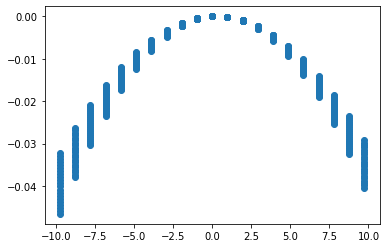

In [142]:
plt.scatter(*np.reshape(np.transpose(path1_det_coords[5,5,5],(2,0,1)),(2,-1)))

In [143]:
import scipy

interp_coords = np.reshape(path1_det_coords[5,5,5], (-1,2))
interp_dist = np.reshape(path1_dist[5,5,5], (-1))
detector_grid_dist_flat = scipy.interpolate.griddata(interp_coords,interp_dist,detector_grid_2d_flat)

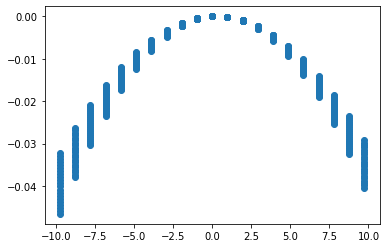

In [144]:
plt.scatter(*np.transpose(interp_coords))

In [145]:
detector_grid_dist_2d = np.reshape(detector_grid_dist_flat, detector_grid_2d.shape[:2])

In [146]:
detector_grid_dist_2d

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [147]:
len(np.where(np.logical_not(np.isnan(detector_grid_dist_2d)))[0])

1342

In [148]:
detector_grid_dist_2d[508,306]

nan

In [149]:
detector_grid_dist_2d

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [150]:
path1_det_y[5,5,5,6]

DeviceArray([-0.00551222, -0.00564543, -0.00577867, -0.00591193,
             -0.00604522, -0.00617854, -0.00631189, -0.00644528,
             -0.00657871, -0.00671218, -0.0068457 , -0.00697927,
             -0.00711288, -0.00724655, -0.00738028, -0.00751406,
             -0.00764791, -0.00778182, -0.0079158 , -0.00804985,
             -0.00818398], dtype=float64)

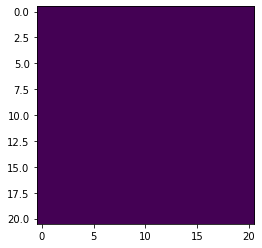

In [151]:
test_xycoords = [0., 0.]
plt.imshow((test_xycoords[0] < path1_det_x[5,5,5]) + (path1_det_x[5,5,5] < test_xycoords[0])
           + (test_xycoords[1] < path1_det_y[5,5,5]) + (path1_det_y[5,5,5] < test_xycoords[1]))

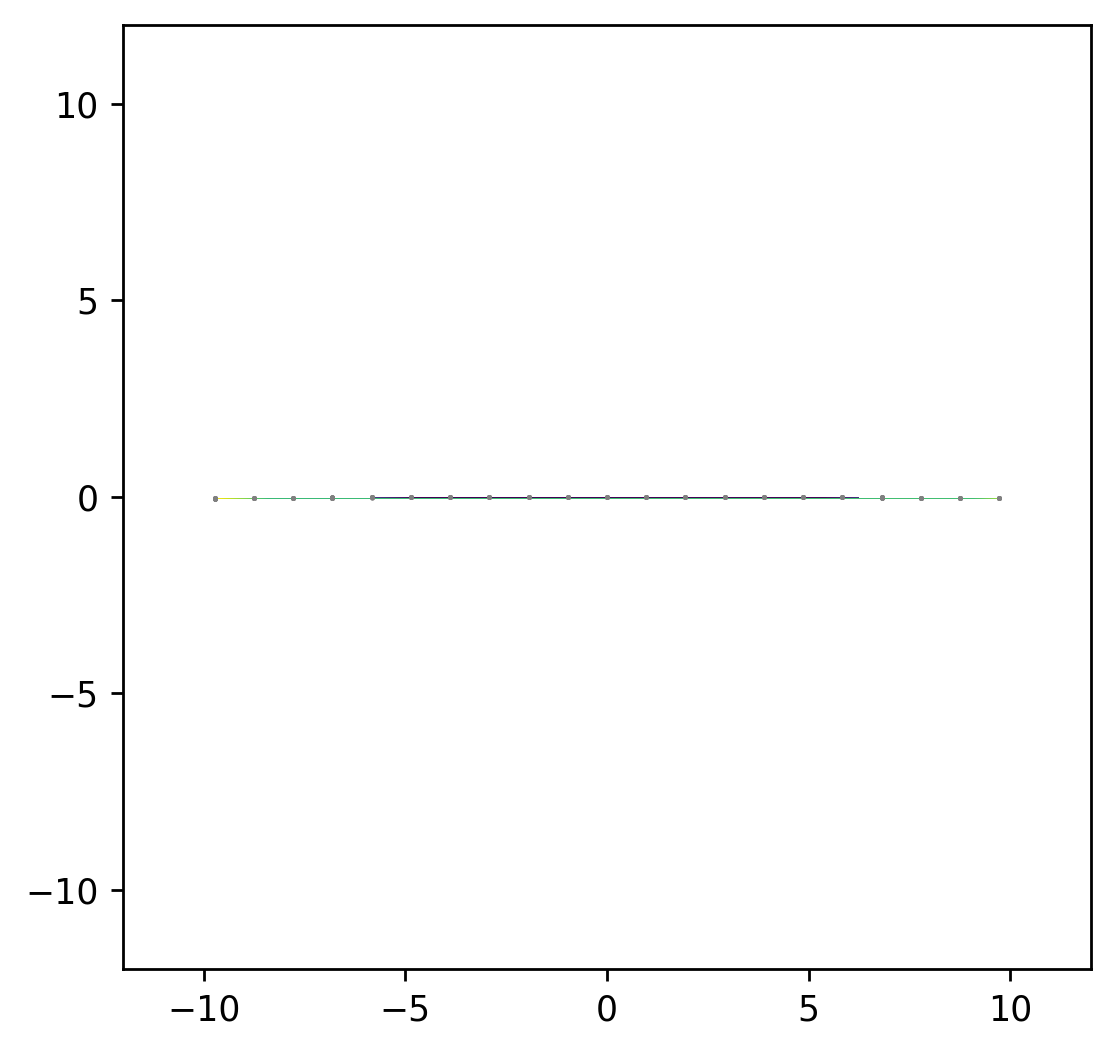

In [152]:
fig, ax = plt.subplots(figsize=(5,5), dpi=250)
ax.pcolormesh(detector_grid_x, detector_grid_y, detector_grid_dist_2d)
ax.scatter(*np.transpose(interp_coords), s=0.1, color='0.5')

### Polygon mapping

In [153]:
# we want to interpolate values at the quadrilateral corners to a regular grid on the detector plane

# let's do this quad by quad (hopefully this will compile to fast code)

# for a given quad:

# 1) determine which points on the detector plane are inside the polygon
# 2) determine the bilinear interpolation function on the quadrilateral
# 3) get the function values at the points

# needs to handle non-convex quadrilaterals

# would be nice to accurately account for light falling into a given detector region even when point at center of region does not fall into raytraced polygon
# could use spatial join to do this; joining polygons against polygons
# this doesn't really work because brightness is not evenly distributed across polygon but depends on how it has been stretched.

# can fix this and do OPD interpolation in the same way by mapping points inside quadrilateral back to telescope plane
# need to handle cases where detector quadrilateral is not convex carefully

In [154]:
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.validation import make_valid
from shapely.strtree import STRtree
import shapely
shapely.speedups.enable()

In [155]:
%%time

n_det_points = 1024

det_elem_length = detector_full_width/(n_det_points-1)

def get_det_idx(pos):
    return int((pos + detector_full_width/2.)//det_elem_length)

detector_grid_1d = np.linspace(-detector_full_width/2., detector_full_width/2., n_det_points)
detector_grid_x, detector_grid_y = np.meshgrid(detector_grid_1d, detector_grid_1d)
detector_grid_2d = np.moveaxis([detector_grid_x, detector_grid_y], 0, -1)
#detector_grid_2d_flat = np.reshape(detector_grid_2d, (-1,2))

detcorner1 = detector_grid_2d[ :-1, :-1]
detcorner2 = detector_grid_2d[1:  , :-1]
detcorner3 = detector_grid_2d[1:  , 1:]
detcorner4 = detector_grid_2d[ :-1, 1:]

detcorners = np.transpose([detcorner1, detcorner2, detcorner3, detcorner4, detcorner1],(1,2,0,3))
detcorners = np.reshape(detcorners, (-1,5,2))
detpolys = list(map(Polygon, detcorners))#[Polygon(c) for c in detcorners]
#detpolys = np.reshape(detpolys, (n_det_points-1, n_det_points-1))
det_rtree = STRtree(detpolys)

CPU times: user 18.7 s, sys: 328 ms, total: 19 s
Wall time: 19 s


In [156]:
def poly_to_idx(detpoly):
    detpoly_centroid = detpoly.centroid.xy
    
    dcen_x = detpoly_centroid[0][0]
    dcen_y = detpoly_centroid[1][0]
    
    didx_x = get_det_idx(dcen_x)
    didx_y = get_det_idx(dcen_y)
    
    return didx_y, didx_x

In [157]:
def my_poly(corners):
    if not np.any(np.isnan(corners)):
        retpoly = Polygon(corners)
    else:
        #there are nan corners, return a dummy polygon
        retpoly = Polygon([[-500, -500],
                           [-500, -501],
                           [-501, -501],
                           [-501, -500]])
    return make_valid(retpoly)

In [158]:
def grid_to_corners(coord_grid):
    corner1 = coord_grid[:, :, :,  :-1,  :-1]
    corner2 = coord_grid[:, :, :, 1:  ,  :-1]
    corner3 = coord_grid[:, :, :, 1:  , 1:  ]
    corner4 = coord_grid[:, :, :,  :-1, 1:  ]

    corners = np.moveaxis([corner1, corner2, corner3, corner4, corner1], 0, 5)
    
    return corners

In [159]:
def get_detector_polygons(system_rays):
    
    path_dist = system_rays[-1].dist_phase
    distcorners = grid_to_corners(path_dist)
    
    det_coords = detector.detector_coords(system_rays[-2])
    polycorners = grid_to_corners(det_coords)

    polys = np.empty(polycorners.shape[:-2], dtype=Polygon)

    for iwave in range(polycorners.shape[0]):
        for ilength in range(polycorners.shape[1]):
            for iwidth in range(polycorners.shape[2]):
                for itel_width in range(polycorners.shape[3]):
                    for itel_height in range(polycorners.shape[4]):
                        polys[iwave, ilength, iwidth, itel_width, itel_height] = my_poly(polycorners[iwave, ilength, iwidth, itel_width, itel_height])
                        
    return polys, polycorners, distcorners

In [160]:
system_interp_rays_path1[-1].dist_phase.shape

(11, 11, 11, 21, 21)

In [161]:
%%time
detpolys_path1, detcorners_path1, detcorner_dist_path1 = get_detector_polygons(system_interp_rays_path1)
detpolys_path2, detcorners_path2, detcorner_dist_path2 = get_detector_polygons(system_interp_rays_path2)

CPU times: user 54.5 s, sys: 391 ms, total: 54.9 s
Wall time: 54.7 s


In [162]:
(detcorner_dist_path1-detcorner_dist_path2)[4,5,5,:,5]/(1e-6*heterodyne_wavelength)

array([[ 2.42221031e+00,  2.18088398e+00,  2.17793519e+00,
         2.41894319e+00,  2.42221031e+00],
       [ 2.18088398e+00,  1.93928892e+00,  1.93665803e+00,
         2.17793519e+00,  2.18088398e+00],
       [ 1.93928892e+00,  1.69745570e+00,  1.69514232e+00,
         1.93665803e+00,  1.93928892e+00],
       [ 1.69745570e+00,  1.45541480e+00,  1.45341859e+00,
         1.69514232e+00,  1.69745570e+00],
       [ 1.45541480e+00,  1.21319664e+00,  1.21151732e+00,
         1.45341859e+00,  1.45541480e+00],
       [ 1.21319664e+00,  9.70831571e-01,  9.69468891e-01,
         1.21151732e+00,  1.21319664e+00],
       [ 9.70831571e-01,  7.28349888e-01,  7.27303655e-01,
         9.69468891e-01,  9.70831571e-01],
       [ 7.28349888e-01,  4.85781851e-01,  4.85051911e-01,
         7.27303655e-01,  7.28349888e-01],
       [ 4.85781851e-01,  2.43157686e-01,  2.42743925e-01,
         4.85051911e-01,  4.85781851e-01],
       [ 2.43157686e-01,  5.07593587e-04,  4.09949724e-04,
         2.42743925e-01

In [163]:
detcorner_dist_path1.shape

(11, 11, 11, 20, 20, 5)

In [164]:
detcorners_path1.shape

(11, 11, 11, 20, 20, 5, 2)

(20, 20, 5, 2)


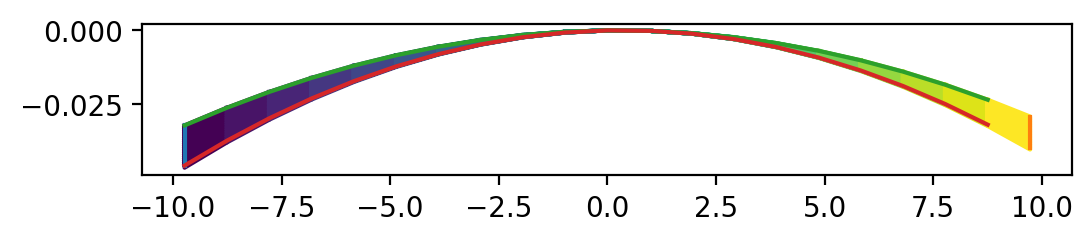

In [321]:
iwave, ilength, iwidth = 5, 5, 5

testpolys = detpolys_path1[iwave, ilength, iwidth]
testcorners = detcorners_path1[iwave, ilength, iwidth]

fig, ax = plt.subplots(figsize=(6,1), dpi=200)
print(testcorners.shape)
rowcolor = mpl.colormaps['viridis']

for i_row, c_row in enumerate(testcorners):
    for i_col, c in enumerate(c_row):
        ax.plot(*np.transpose(c), color=rowcolor(i_row/(testcorners.shape[0]-1)))

ax.plot(*np.transpose(testcorners[0,:,0]))
ax.plot(*np.transpose(testcorners[-1,:,1]))
ax.plot(*np.transpose(testcorners[:,0,0]))
ax.plot(*np.transpose(testcorners[:,-1,0]))
#plt.title('slit center')
# [ax.plot(*np.transpose(c)) for c in corners];
#ax.scatter(np.ravel(detector_grid_x), np.ravel(detector_grid_y), s=0.1, color='k')
#ax.scatter(*corners[0,3])
#ax.set_xlim(-4, 0.25)
#ax.set_ylim(-2.715, -2.64)
#ax.set_xlim(-detector_full_width/2, detector_full_width/2.);
#ax.set_ylim(-detector_full_width/2, detector_full_width/2.);
#plt.xlim(-1,1)
#plt.ylim(-1,1)

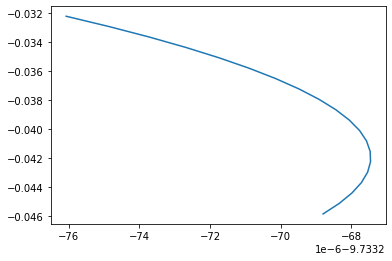

In [312]:
testcorners.shape

(20, 20, 5, 2)

array([[-9.73327608, -0.03223013],
       [-9.73327486, -0.03294539],
       [-9.73327373, -0.03366078],
       [-9.73327269, -0.03437631],
       [-9.73327175, -0.03509198],
       [-9.7332709 , -0.03580783],
       [-9.73327014, -0.03652386],
       [-9.73326948, -0.03724008],
       [-9.73326891, -0.03795652],
       [-9.73326843, -0.03867318],
       [-9.73326805, -0.03939009],
       [-9.73326776, -0.04010726],
       [-9.73326756, -0.04082469],
       [-9.73326746, -0.04154242],
       [-9.73326745, -0.04226045],
       [-9.73326753, -0.0429788 ],
       [-9.73326771, -0.04369748],
       [-9.73326798, -0.04441651],
       [-9.73326834, -0.0451359 ],
       [-9.7332688 , -0.04585568]])

In [166]:
def find_telescope_to_detector_transform(detector_corners, telescope_corners=None):
    # input: length 4 array of detector (x, y) positions resulting from mapping telescope rays to detector
    #        ordering must correspond to telescope plane order (bottom left, bottom right, top right, top left)
    
    if detector_corners.shape != (4, 2):
        raise ValueError('detector_coords shape must be (4, 2)')

    # this is the inverse of the matrix made from points ((0,0),(1,0),(1,1),(0,1))
    if telescope_corners is None:
        coefmatinv = [[ 1,  0,  0,  0],
                      [-1,  1,  0,  0],
                      [-1,  0,  0,  1],
                      [ 1, -1,  1, -1]]
    else:
        xtel = telescope_corners[:,0]
        ytel = telescope_corners[:,1]
        
        coefmat = np.empty((4,4))
        coefmat[:,0] = 1.
        coefmat[:,1] = xtel
        coefmat[:,2] = ytel
        coefmat[:,3] = xtel*ytel
        
        coefmatinv = np.linalg.inv(coefmat)
    
    xcoefs = np.matmul(coefmatinv, detector_corners[:,0])
    ycoefs = np.matmul(coefmatinv, detector_corners[:,1])
    
    return xcoefs, ycoefs

In [167]:
def transform_detector_points_to_telescope_plane(points, detpoly, detector_corners):
    # inputs: points: 2d points to transform to telescope plane
    #         detpoly: detector polygon that maps to a square on the telescope plane
    #                  (may be a multipolygon if detector quadrilateral has a criss-cross)
    #         detector_corners: corners of detector quadrilateral that map to corners of the unit square in the telescope plane
    
    if detpoly.type == 'MultiPolygon':
        poly_points = [np.array(p.boundary.xy) for p in detpoly]
        poly_points = np.transpose(np.unique(np.concatenate(poly_points, axis=1), axis=1))
        poly_cross_point = [a for a in poly_points if a not in detector_corners][0]

        # edge vectors that map to y = +/-1
        u1 = detector_corners[1] - detector_corners[0]
        u2 = detector_corners[2] - detector_corners[3]

        # edge vectors that map to x = +/-1
        v1 = detector_corners[3] - detector_corners[0]
        v2 = detector_corners[2] - detector_corners[1]

        # check if top/bottom edges cross
        q1 = (poly_cross_point - detector_corners[0]) / u1
        if not np.isclose(q1[0], q1[1]) and q1[0]<1 and q1[0]>0:
            raise ValueError('crossed polygon is not top/bottom crossing')
        q1 = q1[0]

        q2 = (poly_cross_point - detector_corners[3]) / u2
        if not np.isclose(q2[0], q2[1]) and q2[0]<1 and q2[0]>0:
            raise ValueError('crossed polygon is not top/bottom crossing')
        q2 = q2[0]
        
        quad_A_corners = np.array([detector_corners[0], 
                                   poly_cross_point, 
                                   poly_cross_point,
                                   detector_corners[3]])
        tel_A_corners = np.array([[0,0],[q1,0],[q2,1],[0,1]])
        quad_A = Polygon(quad_A_corners)
        
        quad_B_corners = np.array([poly_cross_point,
                                   detector_corners[1], 
                                   detector_corners[2], 
                                   poly_cross_point])
        tel_B_corners = np.array([[q1,0],[1,0],[1,1],[q2,1]])
        quad_B = Polygon(quad_B_corners)
        
        eps=1e-10
        detpoints = [p for p in points if not np.all(np.isclose(p, poly_cross_point))]
        pts_A = np.unique(np.array([p for p in detpoints if quad_A.distance(Point(p))<eps]), axis=0)
        pts_B = np.unique(np.array([p for p in detpoints if quad_B.distance(Point(p))<eps]), axis=0)
        
        if len(pts_A)+len(pts_B)<len(np.unique(detpoints, axis=0)):
            raise ValueError('some points are not inside polygon!')
        
        tel_points = []
        if len(pts_A)>0:
            tel_points_A = transform_detector_points_to_telescope_plane_convex(pts_A,
                                                                               quad_A_corners,
                                                                               telescope_corners=tel_A_corners)
            tel_points.append(tel_points_A)
        if len(pts_B)>0:
            tel_points_B = transform_detector_points_to_telescope_plane_convex(pts_B,
                                                                               quad_B_corners,
                                                                               telescope_corners=tel_B_corners)
            tel_points.append(tel_points_B)
        
        if np.any([np.all(np.isclose(p, poly_cross_point)) for p in points]):
            # one of the input points is the crossing point
            tel_points.append(np.array([[q1, 0],[q2, 1]]))
        
        tel_points = np.unique(np.concatenate(tel_points), axis=0)
    else:
        tel_points = transform_detector_points_to_telescope_plane_convex(points, detector_corners)
    
    return tel_points

# def transform_detector_points_to_telescope_plane_crossed(points, detpoly, detector_corners):
#     poly_points = [np.array(p.boundary.xy) for p in detpoly]
#     poly_points = np.transpose(np.unique(np.concatenate(poly_points, axis=1), axis=1))
#     poly_cross_point = [a for a in poly_points if a not in detector_corners][0]
    
#     # edge vectors that map to y = +/-1
#     u1 = detector_corners[1] - detector_corners[0]
#     u2 = detector_corners[2] - detector_corners[3]

#     # edge vectors that map to x = +/-1
#     v1 = detector_corners[3] - detector_corners[0]
#     v2 = detector_corners[2] - detector_corners[1]
    
#     # check if top/bottom edges cross
#     q1 = (poly_cross_point - detector_corners[0]) / u1
#     if not np.isclose(q1[0], q1[1]) and q1[0]<1 and q1[0]>0:
#         raise ValueError('crossed polygon is not top/bottom crossing')
#     q1 = q1[0]

#     q2 = (poly_cross_point - detector_corners[3]) / u2
#     if not np.isclose(q2[0], q2[1]) and q2[0]<1 and q2[0]>0:
#         raise ValueError('crossed polygon is not top/bottom crossing')
#     q2 = q2[0]
    
#     triangle_A = Polygon([detector_corners[0], detector_corners[3], poly_cross_point])
#     triangle_B = Polygon([detector_corners[1], detector_corners[2], poly_cross_point])
    
#     retpoints = []
#     for p in points:
#         print(p)
#         if np.all(np.isclose(p, poly_cross_point)):
#             retpoints.append([q1, 0])
#             retpoints.append([q2, 1])
#         elif triangle_A.covers(Point(p)):
#             t = (v1[0]*p[1] - v1[1]*p[0])/(v1[0]*u1[1] - v1[1]*u1[0])
#             print(t)
#             if t > q1 or t < 0:
#                 raise ValueError('t>q1 or t<0 but point inside triangle A')
#             s = (p[0] - t*u1[0])/((1-t/q1)*v1[0])
#             r = t/q1*((1-s)*q1 + s*q2)
#             retpoints.append([r, s])
#         elif triangle_B.covers(Point(p)):
#             t = (v2[0]*p[1] - v2[1]*p[0])/(v2[0]*u1[1] - v2[1]*u1[0])
#             print(t)
#             if t < q1 or t > 1:
#                 raise ValueError('t<q1 or t>1 but point inside triangle B')
#             s = (p[0] - t*u1[0])/v2[0]*(1-q1)/(t-q1)
#             r = (t-q1)/(1-q1)*((1-s)*(1-q1) + s*(1-q2)) + ((1-s)*q1 + s*q2)
#             retpoints.append([r, s])
#         else:
#             raise ValueError('no matching point in telescope plane')
            
#     #retpoints = np.unique(retpoints, axis=1)
    
#     return retpoints

from numba import njit

#@njit
def transform_detector_points_to_telescope_plane_convex(points, detector_corners, telescope_corners=None):
    #TODO: speed this up by 100x
    
    def find_telescope_to_detector_transform(detector_corners, telescope_corners=None):
        # input: length 4 array of detector (x, y) positions resulting from mapping telescope rays to detector
        #        ordering must correspond to telescope plane order (bottom left, bottom right, top right, top left)

        if detector_corners.shape != (4, 2):
            raise ValueError('detector_coords shape must be (4, 2)')

        # this is the inverse of the matrix made from points ((0,0),(1,0),(1,1),(0,1))
        if telescope_corners is None:
            coefmatinv = np.array([[ 1.,  0.,  0.,  0.],
                                   [-1.,  1.,  0.,  0.],
                                   [-1.,  0.,  0.,  1.],
                                   [ 1., -1.,  1., -1.]])
        else:
            xtel = telescope_corners[:,0]
            ytel = telescope_corners[:,1]

            coefmat = np.empty((4,4))
            coefmat[:,0] = 1.
            coefmat[:,1] = xtel
            coefmat[:,2] = ytel
            coefmat[:,3] = xtel*ytel

            coefmatinv = np.linalg.inv(coefmat)
        
        xcoefs = np.dot(coefmatinv, detector_corners[:,0])
        ycoefs = np.dot(coefmatinv, detector_corners[:,1])

        return xcoefs, ycoefs
    
    xcoefs, ycoefs = find_telescope_to_detector_transform(detector_corners, telescope_corners=telescope_corners)

    if telescope_corners is None:
        telescope_corners = np.array([[0.,0.], [1.,0.], [1.,1.], [0.,1.]])
    
    def is_inside(pt, eps=1e-4):
        xpt = pt[0]
        ypt = pt[1]
        
        if np.any(np.isnan(pt)):
            return False
        
        if ypt < 0-eps or ypt > 1+eps:
            return False
        
        xbound_lower = (1-ypt)*telescope_corners[0,0] + ypt*telescope_corners[3,0]
        xbound_upper = (1-ypt)*telescope_corners[1,0] + ypt*telescope_corners[2,0]
        
        if xpt < xbound_lower-eps or xpt > xbound_upper+eps:
            return False
        
        return True

    tel_points = np.empty((len(points), 2))
    eps=1e-6
    for i, pt in enumerate(points):
        
        det_x = pt[0]
        det_y = pt[1]

        # set up quadratic equation for inverting transformation
        c0 = ycoefs[1]*(xcoefs[0] - det_x) + xcoefs[1]*(-ycoefs[0] + det_y)
        c1 = xcoefs[2]*ycoefs[1] - xcoefs[1]*ycoefs[2] + xcoefs[0]*ycoefs[3] - ycoefs[3]*det_x + xcoefs[3]*(-ycoefs[0] + det_y)
        c2 = -xcoefs[3]*ycoefs[2] + xcoefs[2]*ycoefs[3]

        tel_y_opts = np.empty((2))
        tel_y_opts[:] = np.real(np.roots(np.array([c2, c1, c0], dtype=np.complex128)))
        tel_x_opts = np.empty((2))
        tel_x_opts[0] = (-xcoefs[0] + det_x - xcoefs[2]*tel_y_opts[0])/(xcoefs[1] + xcoefs[3]*tel_y_opts[0])
        tel_x_opts[1] = (-xcoefs[0] + det_x - xcoefs[2]*tel_y_opts[1])/(xcoefs[1] + xcoefs[3]*tel_y_opts[1])

        det_x_check = xcoefs[0] + xcoefs[1]*tel_x_opts + xcoefs[2]*tel_y_opts + xcoefs[3]*tel_x_opts*tel_y_opts
        det_y_check = ycoefs[0] + ycoefs[1]*tel_x_opts + ycoefs[2]*tel_y_opts + ycoefs[3]*tel_x_opts*tel_y_opts

        tel_point_options = np.empty((2,2))
        tel_point_options[:,0] = tel_x_opts
        tel_point_options[:,1] = tel_y_opts
        det_check = np.empty((2,2))
        det_check[:,0] = det_x_check
        det_check[:,1] = det_y_check
        
        if is_inside(tel_point_options[0]) and is_inside(tel_point_options[1]):
            # there are two possibilities for the telescope origin point
            # see if we can reject one using some simple sanity checks
            for i_opt, opt in enumerate(tel_point_options):
                if np.abs(opt[1]-1.0) < eps:
                    # check and see if the point is actually on the top line of the detector quadrilateral
                    pcoef = (pt-detector_corners[3])/(detector_corners[2]-detector_corners[3])
                    if np.abs(pcoef[0]-pcoef[1]) < eps:
                        # this point really is where the solution says, make the other solution invalid
                        tel_point_options[(i_opt+1)%2] = np.nan
                    else:
                        opt[:] = np.nan
                if np.abs(opt[1]) < eps:
                    # check and see if the point is actually on the bottom line of the detector quadrilateral
                    pcoef = (pt-detector_corners[0])/(detector_corners[1]-detector_corners[0])
                    if np.abs(pcoef[0]-pcoef[1]) < eps:
                        # this point really is where the solution says, make the other solution invalid
                        tel_point_options[(i_opt+1)%2] = np.nan
                    else:
                        opt[:] = np.nan
                if np.abs(opt[0]-1.0) < eps:
                    # check and see if the point is actually on the right line of the detector quadrilateral
                    pcoef = (pt-detector_corners[1])/(detector_corners[2]-detector_corners[1])
                    if np.abs(pcoef[0]-pcoef[1]) < eps:
                        # this point really is where the solution says, make the other solution invalid
                        tel_point_options[(i_opt+1)%2] = np.nan
                    else:
                        opt[:] = np.nan
                if np.abs(opt[0]) < eps:
                    # check and see if the point is actually on the bottom line of the detector quadrilateral
                    pcoef = (pt-detector_corners[0])/(detector_corners[3]-detector_corners[0])
                    if np.abs(pcoef[0]-pcoef[1]) < eps:
                        # this point really is where the solution says, make the other solution invalid
                        tel_point_options[(i_opt+1)%2] = np.nan
                    else:
                        opt[:] = np.nan
        if is_inside(tel_point_options[0]) and is_inside(tel_point_options[1]):
            raise ValueError('More than one matching point in telescope plane!')
        elif np.all(np.abs(det_check[0]-pt) < eps) and is_inside(tel_point_options[0]):
            tel_points[i] = tel_point_options[0]
        elif np.all(np.abs(det_check[1]-pt) < eps) and is_inside(tel_point_options[1]):
            tel_points[i] = tel_point_options[1]
        else:
            raise ValueError('no matching point in telescope plane')

    for tpt in tel_points:
         for tc in tpt:
            if tc > 1.:
                tc = 1.
            if tc < 0.:
                tc = 0.
    #tel_points[tel_points > 1.] = 1.
    #tel_points[tel_points < 0.] = 0.
    
    return tel_points

In [168]:
mat = np.random.rand(3,3)
vec = np.random.rand(3)
np.matmul(mat, vec)

array([0.69132548, 0.51519591, 0.73746862])

In [169]:
np.dot(mat, vec)

array([0.69132548, 0.51519591, 0.73746862])

#### detector -> telescope mapping testing

In [170]:
testpolys = np.reshape(testpolys, (-1))
testcorners = np.reshape(testcorners, (-1, 5, 2))

In [171]:
testpolys.shape

(400,)

In [172]:
crossed_poly_idxs = np.array([i for i, p in enumerate(testpolys) if p.type == 'MultiPolygon'])
crossed_poly_idxs

array([180, 183, 184, 187, 189, 191, 201, 202, 205, 206, 208, 210, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239])

In [173]:
i_testpoly = crossed_poly_idxs[0]

vpoly = make_valid(testpolys[i_testpoly])

In [174]:
vpoly_points = np.transpose(np.unique(np.concatenate([np.array(p.boundary.xy) for p in vpoly],axis=1),axis=1))

In [175]:
vpoly_points

array([[-9.72028614e-01, -4.57258657e-04],
       [-9.72028611e-01, -4.71486120e-04],
       [-4.61845734e-09, -2.06356546e-12],
       [-3.90714647e-14,  1.09016431e-13],
       [ 2.66214485e-14,  1.76647511e-13]])

In [176]:
vpoly_vertex = [a for a in vpoly_points if a not in testcorners[i_testpoly]][0]
vpoly_vertex

array([-4.61845734e-09, -2.06356546e-12])

In [177]:
fake_scale = np.array([0.1,0.001])

fake_detpixel_corners = fake_scale*np.array([[-1, -1],
                                             [ 1, -1],
                                             [ 1,  1],
                                             [-1,  1],
                                             [-1, -1]]) + vpoly_vertex
fake_detpixel_poly = Polygon(fake_detpixel_corners)

In [178]:
fake_ipoly = vpoly.intersection(fake_detpixel_poly)

In [179]:
fake_ipoly_coords = np.array([np.array(p.boundary.xy) for p in fake_ipoly])

In [180]:
fake_ipoly_coords

array([[[-1.00000005e-01, -4.61845734e-09, -1.00000005e-01,
         -1.00000005e-01],
        [-4.70416890e-05, -2.06356546e-12, -4.85053767e-05,
         -4.70416890e-05]],

       [[-4.61845734e-09,  2.66214485e-14, -3.90714647e-14,
         -4.61845734e-09],
        [-2.06356546e-12,  1.76647511e-13,  1.09016431e-13,
         -2.06356546e-12]]])

In [181]:
fake_ipoly_corners = np.unique(np.concatenate(fake_ipoly_coords[...,:-1], axis=1),axis=1)
fake_ipoly_corners

array([[-1.00000005e-01, -1.00000005e-01, -4.61845734e-09,
        -3.90714647e-14,  2.66214485e-14],
       [-4.85053767e-05, -4.70416890e-05, -2.06356546e-12,
         1.09016431e-13,  1.76647511e-13]])

In [182]:
np.transpose(testcorners[i_testpoly][:-1])

array([[-9.72028614e-01, -3.90714647e-14,  2.66214485e-14,
        -9.72028611e-01],
       [-4.57258657e-04,  1.09016431e-13,  1.76647511e-13,
        -4.71486120e-04]])

In [183]:
my_intermediate_corners=np.copy(testcorners[i_testpoly][:-1])
f = 0.5
my_intermediate_corners[0,:] = (1-f)*my_intermediate_corners[0,:] + f*my_intermediate_corners[1,:]

In [184]:
testcorners[i_testpoly][:-1]

array([[-9.72028614e-01, -4.57258657e-04],
       [-3.90714647e-14,  1.09016431e-13],
       [ 2.66214485e-14,  1.76647511e-13],
       [-9.72028611e-01, -4.71486120e-04]])

In [185]:
my_intermediate_corners

array([[-4.86014307e-01, -2.28629328e-04],
       [-3.90714647e-14,  1.09016431e-13],
       [ 2.66214485e-14,  1.76647511e-13],
       [-9.72028611e-01, -4.71486120e-04]])

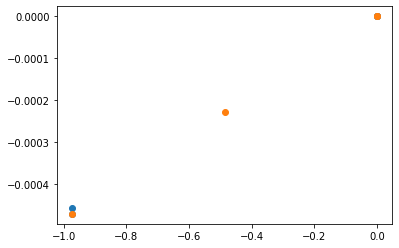

In [186]:
plt.scatter(*np.transpose(testcorners[i_testpoly][:-1]))
plt.scatter(*np.transpose(my_intermediate_corners))

In [187]:
%pdb off

Automatic pdb calling has been turned OFF


In [188]:
my_intermediate_corners

array([[-4.86014307e-01, -2.28629328e-04],
       [-3.90714647e-14,  1.09016431e-13],
       [ 2.66214485e-14,  1.76647511e-13],
       [-9.72028611e-01, -4.71486120e-04]])

In [189]:
transform_detector_points_to_telescope_plane_convex(my_intermediate_corners, # corners[i_testpoly][:-1], # np.transpose(fake_ipoly_corners), # 
                                                    testcorners[i_testpoly][:-1])

array([[5.00000000e-01, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.99999786e-01],
       [4.25491906e-25, 1.00000000e+00]])

In [190]:
my_intermediate_corners

array([[-4.86014307e-01, -2.28629328e-04],
       [-3.90714647e-14,  1.09016431e-13],
       [ 2.66214485e-14,  1.76647511e-13],
       [-9.72028611e-01, -4.71486120e-04]])

In [191]:
fake_ipoly_corners

array([[-1.00000005e-01, -1.00000005e-01, -4.61845734e-09,
        -3.90714647e-14,  2.66214485e-14],
       [-4.85053767e-05, -4.70416890e-05, -2.06356546e-12,
         1.09016431e-13,  1.76647511e-13]])

In [192]:
fake_telpts = transform_detector_points_to_telescope_plane_convex(my_intermediate_corners, # corners[i_testpoly][:-1], # 
                                                                  #vpoly, 
                                                                  testcorners[i_testpoly][:-1])
fake_telpts

array([[5.00000000e-01, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.99999786e-01],
       [4.25491906e-25, 1.00000000e+00]])

In [193]:
MultiPoint(fake_telpts).convex_hull.boundary.xy[0][:]

array('d', [0.5, 4.2549190590263595e-25, 1.0, 1.0, 0.5])

Text(0.5, 1.0, 'Telescope Polygon')

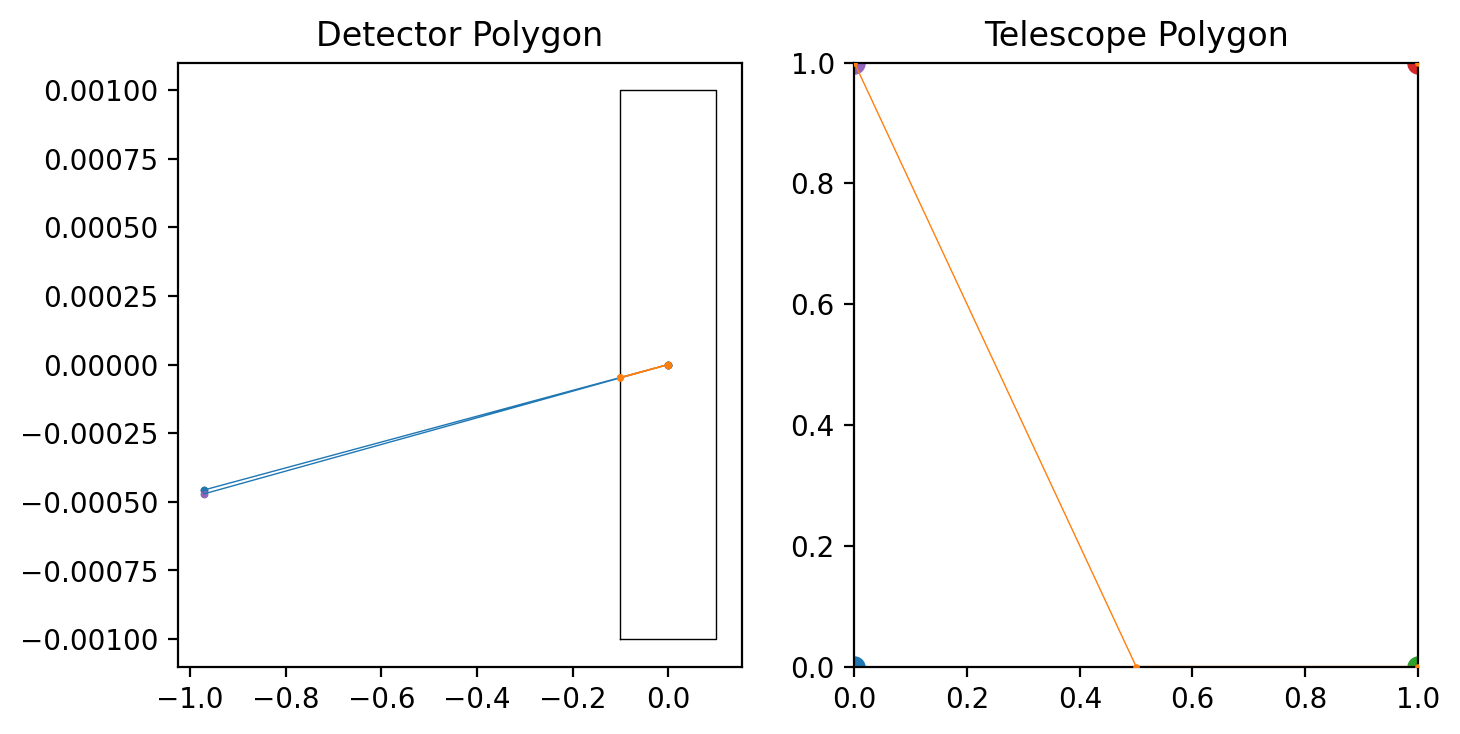

In [194]:
fig, (ax_det, ax_tel) = plt.subplots(ncols=2, figsize=(8,4), dpi=200)

ax_det.scatter(*np.transpose(testcorners[i_testpoly]), color='0.5', s=3)
[ax_det.plot(*np.array(p.boundary.xy), color='C0', lw=0.5) for p in vpoly]
ax_det.scatter(*vpoly_vertex, s=3)
ax_det.scatter(*(np.transpose(testcorners[i_testpoly][:-1])[:,0]), color='C0', s=3)
ax_det.scatter(*(np.transpose(testcorners[i_testpoly][:-1])[:,1]), color='C2', s=3)
ax_det.scatter(*(np.transpose(testcorners[i_testpoly][:-1])[:,2]), color='C3', s=3)
ax_det.scatter(*(np.transpose(testcorners[i_testpoly][:-1])[:,3]), color='C4', s=3)
ax_det.plot(*np.transpose(fake_detpixel_corners), color='k', lw=0.5)
[ax_det.plot(*np.array(p.boundary.xy), color='C1', lw=0.5) for p in fake_ipoly]
[ax_det.scatter(*np.array(p.boundary.xy), color='C1', s=2, zorder=10) for p in fake_ipoly]
ax_det.set_title('Detector Polygon')

ax_tel.scatter(*np.transpose(fake_telpts), color='C1', s=2, zorder=10)
#plt.plot(*np.transpose(fake_telpts))
ax_tel.plot(MultiPoint(fake_telpts).convex_hull.boundary.xy[0], 
            MultiPoint(fake_telpts).convex_hull.boundary.xy[1],
            color='C1', lw=0.5)
ax_tel.scatter(0, 0, color='C0', s=50)
ax_tel.scatter(1, 0, color='C2', s=50)
ax_tel.scatter(1, 1, color='C3', s=50)
ax_tel.scatter(0, 1, color='C4', s=50)
ax_tel.set_xlim(0,1)
ax_tel.set_ylim(0,1)
ax_tel.set_title('Telescope Polygon')

#### back to work

In [195]:
mypoly = detpolys_path1[iwave, ilength, iwidth, 0, 0]

In [196]:
def get_iregion_coords(iregion):
    # get boundary coordinates for a region of intersection on the detector
    
    if iregion.type in ['Polygon', 'MultiPolygon']:
        if iregion.type == 'MultiPolygon':
            det_icoords = [np.array(p.boundary.xy) for p in iregion]
            det_icoords = np.concatenate(det_icoords, axis=1)
            det_icoords = np.unique(det_icoords, axis=1)
        else:
            if iregion.boundary.type == 'LineString':
                det_icoords = iregion.boundary.xy
            else:
                det_icoords = np.array([np.array(pb.xy) for pb in iregion.boundary])
    elif iregion.area == 0:
        det_icoords = [[],[]]
    
    return np.transpose(det_icoords)

In [197]:
zero_area_telregion = MultiPoint(((0,0),(0,0))).convex_hull

def get_telregion(iregion, poly, pcorners):
    # get telescope coordinates for detector region region
    det_icoords = get_iregion_coords(iregion)

    if len(det_icoords) > 0:
        telpts = transform_detector_points_to_telescope_plane_convex(det_icoords,
                                                                     #poly,
                                                                     pcorners[:-1])
        return MultiPoint(telpts).convex_hull
    else:
        return zero_area_telregion

In [198]:
def bilinear_interp(point, values):
    # point = 2d point in unit square
    # values = length 4 array of function values at corners to interpolate bilinearly
    #          values must correspond to corners (0,0) , (1,0) , (1,1) , (0,1) in that order
    
    bottom_left = values[0]
    bottom_right = values[1]
    top_right = values[2]
    top_left = values[3]
    
    x = point[0]
    y = point[1]
    
    if x<0 or 1<x or y<0 or 1<y:
        raise ValueError('point outside unit square')
        
    retval = (1-x)*(1-y)*bottom_left + x*(1-y)*bottom_right + x*y*top_right + (1-x)*y*top_left
        
    return retval

In [199]:
def get_detector_image(path1_polys_in, path1_corners_in, path1_corner_dist_in, 
                       path2_polys_in, path2_corners_in, path2_corner_dist_in,
                       wavelength=heterodyne_wavelength):
    
    detector_image_grid = np.zeros((n_det_points-1, n_det_points-1))
    
    path1_polys = np.reshape(np.copy(path1_polys_in), (-1))
    path1_corners = np.reshape(np.copy(path1_corners_in), (-1,5,2))
    path1_corner_dist = np.reshape(np.copy(path1_corner_dist_in), (-1,5))
    path2_polys = np.reshape(np.copy(path2_polys_in), (-1))
    path2_corners = np.reshape(np.copy(path2_corners_in), (-1,5,2))
    path2_corner_dist = np.reshape(np.copy(path2_corner_dist_in), (-1,5))
    
    # print(f'{path1_corner_dist-path2_corner_dist=}')
    
    for (poly1, poly1corners, cornerdist1,
         poly2, poly2corners, cornerdist2) in zip(path1_polys, path1_corners, path1_corner_dist, 
                                                  path2_polys, path2_corners, path2_corner_dist):
        
        # determine the possible intersecting detector elements
        polyboth = poly1.union(poly2)
        all_det_possible = det_rtree.query(polyboth)

        # TODO: figure out why the total amount of light returned is too large
        for d in all_det_possible:
            r1 = poly1.intersection(d)
            r2 = poly2.intersection(d)
            # print(f'{r1.area=}')
            # print(f'{r2.area=}')

            # determine whether these regions intersect
            rboth = r1.intersection(r2)
            r1_only = r1.difference(rboth)
            r2_only = r2.difference(rboth)

            # find the corresponding telescope areas
            rboth_tel_1 = get_telregion(rboth, poly1, poly1corners) # zero_area_telregion # 
            rboth_tel_2 = get_telregion(rboth, poly2, poly2corners) # zero_area_telregion # 
            r1_only_tel = get_telregion(r1_only, poly1, poly1corners) # zero_area_telregion # 
            r2_only_tel = get_telregion(r2_only, poly2, poly2corners) # zero_area_telregion # 

            # print(f'{rboth_tel_1.area=}')
            # print(f'{rboth_tel_2.area=}')
            # print(f'{r1_only_tel.area=}')
            # print(f'{r1_only_tel.area=}')

            # now we can add light to the pixel

            # light from each beam that doesn't interfere is easy
            detector_image_grid[poly_to_idx(d)] += r1_only_tel.area
            detector_image_grid[poly_to_idx(d)] += r2_only_tel.area

            # light that interferes is a bit harder

            # we need to get the path length for each beam
            tel_centroid_1 = np.array(rboth_tel_1.centroid.xy)[:,0]
            path1_dist = bilinear_interp(tel_centroid_1, cornerdist1)
            # print(f'{tel_centroid_1=}')
            # print(f'{cornerdist1=}')
            # print(f'{path1_dist=}')
            tel_centroid_2 = np.array(rboth_tel_2.centroid.xy)[:,0]
            path2_dist = bilinear_interp(tel_centroid_2, cornerdist2)
            # print(f'{tel_centroid_2=}')
            # print(f'{cornerdist2=}')
            # print(f'{path2_dist=}')
            
            
            # cornerdiff = np.mean(cornerdist1[:-1])-np.mean(cornerdist2)
            # cornerdiff = 2*np.pi/(1e-6*wavelength)*cornerdiff
            # print(f'{cornerdiff=}')
            
            pdiff = path1_dist - path2_dist
            pdiff = 2*np.pi/(1e-6*wavelength)*pdiff
            # print(f'{pdiff=}')
            
            I1 = rboth_tel_1.area
            I2 = rboth_tel_2.area

            interfered_beam_brightness = I1 + I2 + 2*np.sqrt(I1*I2)*np.cos(pdiff)

            detector_image_grid[poly_to_idx(d)] += interfered_beam_brightness
                
    return detector_image_grid

In [200]:
%%time

iwave, ilength, iwidth = 4, 5, 5

image_wavelength = np.unique(system_interp_rays_path1[-1].wavelengths[iwave])[0]
print(f'{image_wavelength=}')
print(f'{(image_wavelength-heterodyne_wavelength)/minimum_resolvable_wavelength_difference=}')

image_wavelength=121.55869791666667
(image_wavelength-heterodyne_wavelength)/minimum_resolvable_wavelength_difference=-3.999999999985448
CPU times: user 18.6 ms, sys: 0 ns, total: 18.6 ms
Wall time: 18.1 ms


In [201]:
%%time
detector_brightness_center = get_detector_image(detpolys_path1[iwave, ilength, iwidth], #, [0,1], [0,1]], 
                                                detcorners_path1[iwave, ilength, iwidth], #, [0,1], [0,1]], 
                                                detcorner_dist_path1[iwave, ilength, iwidth], #, [0,1], [0,1]],
                                                detpolys_path2[iwave, ilength, iwidth], #, [0,1], [0,1]], 
                                                detcorners_path2[iwave, ilength, iwidth], #, [0,1], [0,1]], 
                                                detcorner_dist_path2[iwave, ilength, iwidth], #, [0,1], [0,1]],
                                                wavelength=image_wavelength)

CPU times: user 1min 16s, sys: 4.64 ms, total: 1min 16s
Wall time: 1min 16s


In [202]:
np.sum(detector_brightness_center)

869.0904481470222

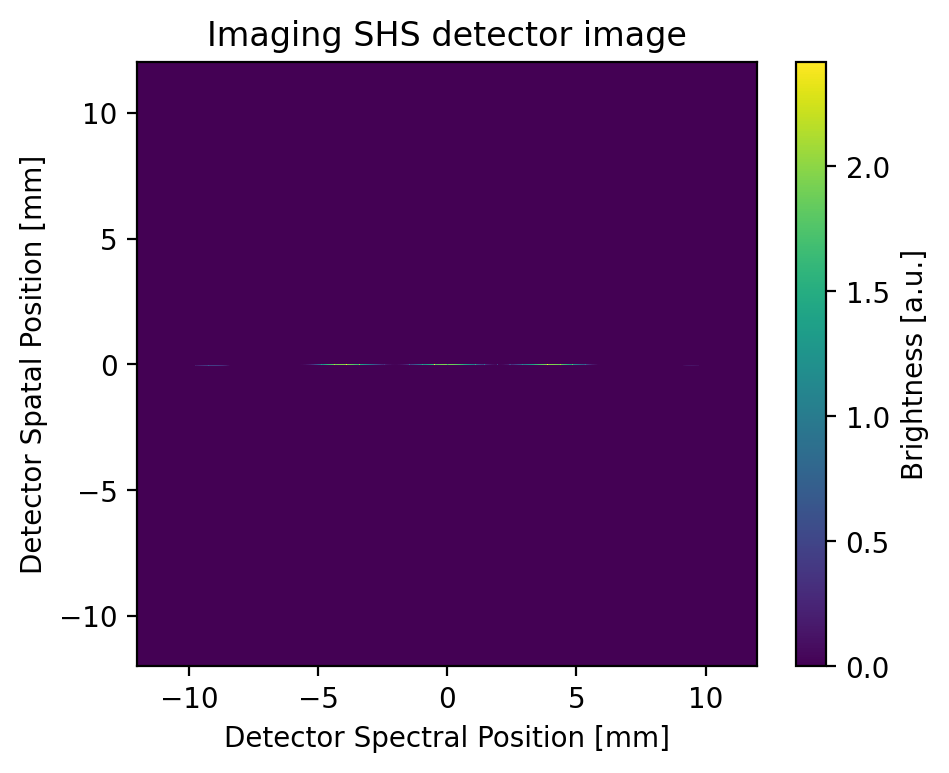

In [203]:
fig, ax = plt.subplots(figsize=(5,4), dpi=200)
dimg = ax.pcolormesh(detector_grid_x, detector_grid_y, detector_brightness_center)#, cmap='Greys_r')
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.colorbar(dimg, label='Brightness [a.u.]')

ax.set_ylabel('Detector Spatal Position [mm]');
ax.set_xlabel('Detector Spectral Position [mm]');
ax.set_title('Imaging SHS detector image');

In [204]:
%%time

iwave, ilength, iwidth = 4, 5, 4

image_wavelength = np.unique(system_interp_rays_path1[-1].wavelengths[iwave])[0]
print(f'{image_wavelength=}')
print(f'{(image_wavelength-heterodyne_wavelength)/minimum_resolvable_wavelength_difference=}')

detector_brightness_wave1 = get_detector_image(detpolys_path1[iwave, ilength, iwidth], #, [0,1], [0,1]], 
                                                detcorners_path1[iwave, ilength, iwidth], #, [0,1], [0,1]], 
                                                detcorner_dist_path1[iwave, ilength, iwidth], #, [0,1], [0,1]],
                                                detpolys_path2[iwave, ilength, iwidth], #, [0,1], [0,1]], 
                                                detcorners_path2[iwave, ilength, iwidth], #, [0,1], [0,1]], 
                                                detcorner_dist_path2[iwave, ilength, iwidth], #, [0,1], [0,1]],
                                                wavelength=image_wavelength)

image_wavelength=121.55869791666667
(image_wavelength-heterodyne_wavelength)/minimum_resolvable_wavelength_difference=-3.999999999985448
CPU times: user 1min 14s, sys: 1.05 ms, total: 1min 14s
Wall time: 1min 14s


In [205]:
np.sum(detector_brightness_wave1)

819.0215078974257

Text(0.5, 1.0, 'Imaging SHS detector image')

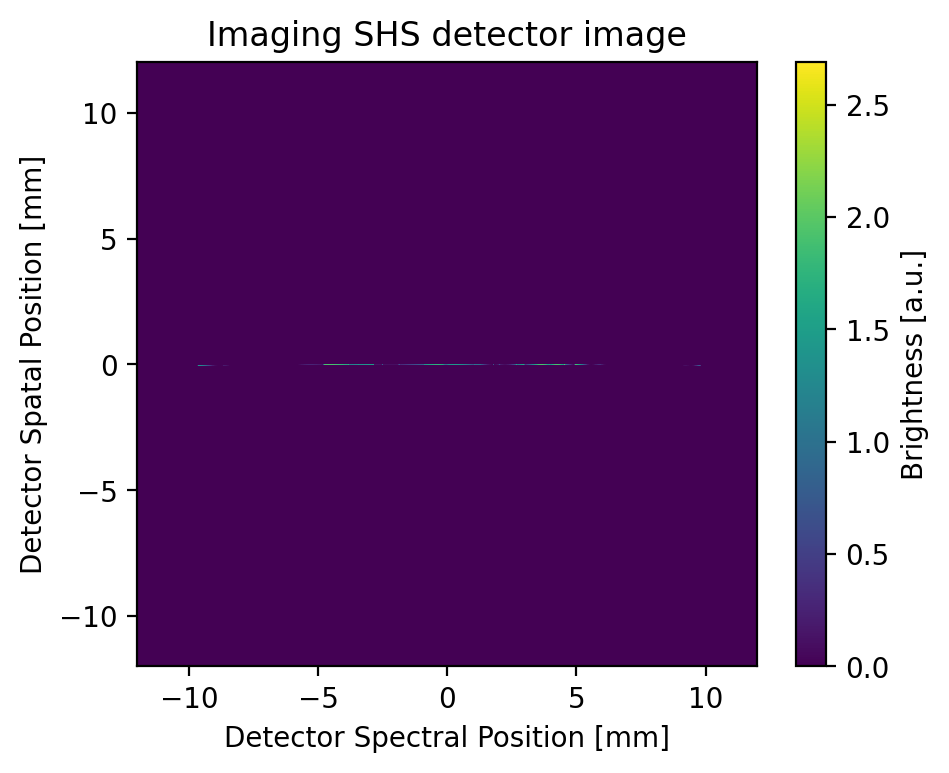

In [206]:
fig, ax = plt.subplots(figsize=(5,4), dpi=200)
dimg = ax.pcolormesh(detector_grid_x, detector_grid_y, detector_brightness_wave1)#, cmap='Greys_r')
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.colorbar(dimg, label='Brightness [a.u.]')

ax.set_ylabel('Detector Spatal Position [mm]');
ax.set_xlabel('Detector Spectral Position [mm]');
ax.set_title('Imaging SHS detector image')

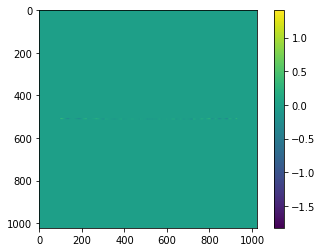

In [207]:
plt.imshow((detector_brightness_wave1-detector_brightness_center))
plt.colorbar()

## Spherical SHS Characterization

### Initial optimization efforts